# Notes:

## fix tick marks on distribution to be only at .1 mile marks 

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Objective: Identify route and stop characteristics:

- Speed of route
- Ridership at stops
- Route spacing

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
import geopandas
import random
import math

In [3]:
print("GTFS data sets: ")
GTFS_DATA_PATH = "mmt_gtfs/"
import os; os.listdir(GTFS_DATA_PATH) # Peak whats in the directory 

GTFS data sets: 


['fare_attributes.txt',
 'transfers.txt',
 'agency.txt',
 'fare_rules.txt',
 'calendar_dates.txt',
 'stop_times.txt',
 'shapes.txt',
 'trips.txt',
 'feed_info.txt',
 'stops.txt',
 'linked_datasets.txt',
 'Metro_Transit_Ridership_by_Route_Weekday.csv',
 'stop_features.txt',
 'calendar.txt',
 'routes.txt',
 'translations.txt']

In [4]:
def getPandasDFCSV(path, file, sep=','):  
    """ Keyword Arg sep: deliminator used in txt file (default = ',')"""
    pandasDF = pd.read_csv(path +  file, sep=sep)
    return pandasDF

In [5]:
stops_df = getPandasDFCSV(GTFS_DATA_PATH, 'stops.txt')
#stops_df.head()

In [6]:
ridership_df = getPandasDFCSV(GTFS_DATA_PATH, 'Metro_Transit_Ridership_by_Route_Weekday.csv')
#ridership_df

In [7]:
stop_times_df = getPandasDFCSV(GTFS_DATA_PATH, 'stop_times.txt')
#stop_times_df.info()
#stop_times_df.head(3)

In [8]:
# Fix the times from strings and bad formatting to datetime objects:

arrivalTimesArray = np.array(stop_times_df['arrival_time'])

arrivalTimesArrayFixed = []
for time in arrivalTimesArray:
    timeList = time.split(":")
    timeList = [int(time) for time in timeList]
    if timeList[0] < 24:
        dateTime = datetime.datetime(2000, 1, 1, timeList[0], timeList[1], timeList[2])
    else:
        dateTime = datetime.datetime(2000, 1, 2, timeList[0]-24, timeList[1], timeList[2])
    arrivalTimesArrayFixed.append(dateTime)
    
stop_times_df['arrival_time'] = arrivalTimesArrayFixed

departureTimesArray = np.array(stop_times_df['departure_time'])

departureTimesArrayFixed = []
for time in departureTimesArray:
    timeList = time.split(":")
    timeList = [int(time) for time in timeList]
    if timeList[0] < 24:
        dateTime = datetime.datetime(2000, 1, 1, timeList[0], timeList[1], timeList[2])
    else:
        dateTime = datetime.datetime(2000, 1, 2, timeList[0]-24, timeList[1], timeList[2])
    departureTimesArrayFixed.append(dateTime)
    
stop_times_df['departure_time'] = departureTimesArrayFixed

#stop_times_df.head()

In [9]:
#stop_times_df.head()

In [10]:
trips_df = getPandasDFCSV(GTFS_DATA_PATH, 'trips.txt')
#trips_df.info()
#trips_df.head(3)

In [11]:
stops_df = getPandasDFCSV(GTFS_DATA_PATH, 'stops.txt')
#stops_df.info()
#stops_df.head(3)

In [12]:
print("list of possible trips: \n")

service_id_list = []
for i in trips_df['service_id']:
    if i not in service_id_list:
        service_id_list.append(i)
print(service_id_list)

list of possible trips: 

['92_WKD', '92_SAT', '92_SUN', '92_HOL', '92_MWK', '92_WKD:R', '92_SAT:R', '92_SUN:R', '92_HOL:R', '92_SAT:L', '92_SUN:L', '92_WKD:L#6', '92_WKD:L=6', '92_WKD:S', '92_SAT:S', '92_SUN:S', '92_WKD:S#6', '92_WKD:S=6']


In [13]:
print("list of possible routes: \n")

route_short_name_list = []
for i in trips_df['route_short_name']:
    if i not in route_short_name_list:
        route_short_name_list.append(i)

route_short_name_list.sort()
print(route_short_name_list)

list of possible routes: 

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 59, 63, 67, 68, 70, 72, 73, 75, 78, 80, 81, 82, 84]


In [14]:
trips_df_weekday_peak = trips_df[trips_df['service_id'] == '92_WKD']
trips_df_weekday_peak_R = trips_df[trips_df['service_id'] == '92_WKD:R']
trips_df_weekday_peak_s = trips_df[trips_df['service_id'] == '92_WKD:L#6']
trips_df_weekday_peak_s3 = trips_df[trips_df['service_id'] == '92_WKD:L=6']
trips_df_weekday_peak_s1 = trips_df[trips_df['service_id'] == '92_WKD:S']
trips_df_weekday_peak_s2 = trips_df[trips_df['service_id'] == '92_WKD:S#6']
trips_df_weekday_peak_s4 = trips_df[trips_df['service_id'] == '92_WKD:S=6']

dfs_wk = [trips_df_weekday_peak, trips_df_weekday_peak_R, trips_df_weekday_peak_s, 
          trips_df_weekday_peak_s1, trips_df_weekday_peak_s2, trips_df_weekday_peak_s4]

trips_df_weekday = pd.concat(dfs_wk)
#trips_df_weekday.info()

In [15]:
print("Routes for weekday trips: \n")

routes_wk_list = []
for route in trips_df_weekday['route_short_name']:
    if route not in routes_wk_list:
        routes_wk_list.append(route)

routes_wk_list.sort()
print(routes_wk_list)

Routes for weekday trips: 

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 67, 70, 72, 73, 75, 80, 81, 82, 84]


In [16]:
# make a dictionary of routes with trip ID's for weekday service:
print("Dictionary of all the possible trips for each route during weekdays: \n\n Example output for 10 trips in route 2: \n")

tripIDList_forRoutes_weekday92 = dict()
for i in routes_wk_list:
    trip_list = []
    for j in trips_df_weekday[trips_df_weekday['route_short_name'] == i].iterrows():
        trip_list.append(j[1]['trip_id'])
    tripIDList_forRoutes_weekday92[i] = trip_list

print(tripIDList_forRoutes_weekday92[2][:10])

Dictionary of all the possible trips for each route during weekdays: 

 Example output for 10 trips in route 2: 

[1007843, 1007844, 1007499, 1007497, 1007481, 1007496, 1007480, 1007495, 1007479, 1007494]


# Find average speed for each route: 

total distance travelled by route / time the route took

In [17]:
ridership_df[ridership_df['Route'] == 7]

totalRiders = np.sum(list(ridership_df['DailyBoardings']))

In [18]:
# Each route has a list [average speed, average stop spacing, percent of total ridership]

route_stops = dict()

totalRidersAll = np.sum(list(ridership_df['DailyBoardings']))

route_characteristics = dict()
for route in tripIDList_forRoutes_weekday92:
    route_characteristics[route] = []
    route_stops[route] = []
    
    stops_list = []
    route_trips_speeds = []
    route_trips_distances = []
    stop_spacing_all = []
    farthest_distances = []
    for trip in tripIDList_forRoutes_weekday92[route]:
        
        # Find speeeds: 
        stop_times_df_local = stop_times_df[stop_times_df['trip_id'] == trip]
        distance = list(stop_times_df_local['shape_dist_traveled'])[-1]
        time = list(stop_times_df_local['departure_time'])[-1] - list(stop_times_df_local['departure_time'])[0]
        speed = distance / (time.seconds / 3600)
        route_trips_speeds.append(speed)
        
        # Find average route spacing:
        spacing_list = []
        spacing = list(stop_times_df_local['shape_dist_traveled'])
        spacing.insert(0, 0.0)
        for i in range(len(spacing)-1):
            stop_spacing = spacing[i+1] - spacing[i]
            spacing_list.append(stop_spacing)
            stop_spacing_all.append(stop_spacing)
        route_trips_distances.append(np.average(spacing_list))
           
        # Add stops to dictionary:
        for stop in stop_times_df_local['stop_id']:
            if stop not in stops_list:
                stops_list.append(stop)
                
        #farthest distances:
        farthest_distances.append(spacing[-1])
        
    # Get daily boardings:
    route_df = ridership_df[ridership_df['Route'] == route]
    totalRiders = np.sum(list(route_df['DailyBoardings']))
    fractionOfTotalRiders = totalRiders/totalRidersAll
    
    # get the distribution of stop spacings:
    stop_spacing_dict = dict()
    stop_spacing_all.sort()
    for i in stop_spacing_all:
        if i not in stop_spacing_dict:
            stop_spacing_dict[i] = 1
        else:
            stop_spacing_dict[i] += 1
    
    route_characteristics[route].append(np.average(route_trips_speeds))
    route_characteristics[route].append(np.average(route_trips_distances))
    route_characteristics[route].append(fractionOfTotalRiders)
    route_characteristics[route].append(stop_spacing_dict)
    route_characteristics[route].append(np.average(farthest_distances))
    route_stops[route] = stops_list
    

#route_characteristics[27]

In [19]:
"""ax = plt.subplots(figsize=(20, 12))[1]

for i, route in enumerate(route_characteristics):
    s = route_characteristics[route]
    
    if route == 80:
        continue
    # ridership vs speed
    markerSp = "$" + str(route) + "$"
    x = s[0]
    y = s[2]
    ax.plot(x, y, color='#34013f', linewidth=3, markersize=10, marker = markerSp, alpha=.9)
    
plt.xlabel("Average Speed (MPH)")
plt.ylabel("fraction of total daily riders")
plt.title("Correlation between Ridership and Speed (Route 80 excluded)")
plt.savefig("Correlation__Ridership_Speed_no80")
plt.show()"""

'ax = plt.subplots(figsize=(20, 12))[1]\n\nfor i, route in enumerate(route_characteristics):\n    s = route_characteristics[route]\n    \n    if route == 80:\n        continue\n    # ridership vs speed\n    markerSp = "$" + str(route) + "$"\n    x = s[0]\n    y = s[2]\n    ax.plot(x, y, color=\'#34013f\', linewidth=3, markersize=10, marker = markerSp, alpha=.9)\n    \nplt.xlabel("Average Speed (MPH)")\nplt.ylabel("fraction of total daily riders")\nplt.title("Correlation between Ridership and Speed (Route 80 excluded)")\nplt.savefig("Correlation__Ridership_Speed_no80")\nplt.show()'

In [20]:
"""ax = plt.subplots(figsize=(20, 12))[1]

for i, route in enumerate(route_characteristics):
    s = route_characteristics[route]
    
    if route == 80:
        continue
    # ridership vs speed
    markerSp = "$" + str(route) + "$"
    x = s[1]
    y = s[2]
    ax.plot(x, y, color='#34013f', linewidth=3, markersize=10, marker = markerSp, alpha=.9)
    
plt.xlabel("Average Stop Spacing (Miles)")
plt.ylabel("fraction of total daily riders")
plt.title("Correlation between Ridership and Stop-Spacing (Route 80 excluded)")
plt.savefig("Correlation_Ridership_Stop-Spacing_no80")
plt.show()"""

'ax = plt.subplots(figsize=(20, 12))[1]\n\nfor i, route in enumerate(route_characteristics):\n    s = route_characteristics[route]\n    \n    if route == 80:\n        continue\n    # ridership vs speed\n    markerSp = "$" + str(route) + "$"\n    x = s[1]\n    y = s[2]\n    ax.plot(x, y, color=\'#34013f\', linewidth=3, markersize=10, marker = markerSp, alpha=.9)\n    \nplt.xlabel("Average Stop Spacing (Miles)")\nplt.ylabel("fraction of total daily riders")\nplt.title("Correlation between Ridership and Stop-Spacing (Route 80 excluded)")\nplt.savefig("Correlation_Ridership_Stop-Spacing_no80")\nplt.show()'

In [21]:
"""ax = plt.subplots(figsize=(20, 12))[1]

for i, route in enumerate(route_characteristics):
    s = route_characteristics[route]
    
    if route in (80, 7, 8):
        continue
    # ridership vs speed
    markerSp = "$" + str(route) + "$"
    x = s[1]
    y = s[2]
    ax.plot(x, y, color='#34013f', linewidth=3, markersize=15, marker = markerSp, alpha=.9)
    ax.set_xlabel("Average Stop Spacing (Miles)")
    ax.set_ylabel("")
    
plt.xlabel("Average Stop Spacing (Miles)", fontsize=14)
plt.ylabel("fraction of total daily riders", fontsize=14)
plt.title("Lowest ridership and closest stop spacing", fontsize=14)
plt.xlim(.16, .21)
plt.ylim(-.001, .015)
plt.savefig("Lowest_ridership_closest_stop_spacing", fontsize=18)
plt.show()"""

'ax = plt.subplots(figsize=(20, 12))[1]\n\nfor i, route in enumerate(route_characteristics):\n    s = route_characteristics[route]\n    \n    if route in (80, 7, 8):\n        continue\n    # ridership vs speed\n    markerSp = "$" + str(route) + "$"\n    x = s[1]\n    y = s[2]\n    ax.plot(x, y, color=\'#34013f\', linewidth=3, markersize=15, marker = markerSp, alpha=.9)\n    ax.set_xlabel("Average Stop Spacing (Miles)")\n    ax.set_ylabel("")\n    \nplt.xlabel("Average Stop Spacing (Miles)", fontsize=14)\nplt.ylabel("fraction of total daily riders", fontsize=14)\nplt.title("Lowest ridership and closest stop spacing", fontsize=14)\nplt.xlim(.16, .21)\nplt.ylim(-.001, .015)\nplt.savefig("Lowest_ridership_closest_stop_spacing", fontsize=18)\nplt.show()'

## Plotting the Routes and Characteriestics:

In [22]:
Routes_latLon = dict()

for route in routes_wk_list:
    lat = []
    lon = []
    stops = route_stops[route]
    for stop in stops:
        stops_local = stops_df[stops_df['stop_id'] == stop]
        lat.append(float(stops_local['stop_lat']))
        lon.append(float(stops_local['stop_lon']))
    Routes_latLon[route] = [lat, lon]

In [23]:
riderships = []
for route in route_characteristics:
    if route == 80: 
        continue
    riderships.append(route_characteristics[route][2])

ridership_avg_no_80 = np.average(riderships)
ridership_avg_no_80

Speeds = []
for route in route_characteristics:
    if route == 80: 
        continue
    Speeds.append(route_characteristics[route][0])

Speeds_avg_no_80 = np.average(Speeds)
Speeds_avg_no_80

spacing = []
for route in route_characteristics:
    if route == 80: 
        continue
    spacing.append(route_characteristics[route][1])

Spacing_avg_no_80 = np.average(spacing)
Spacing_avg_no_80

std_dev = []
for route in route_characteristics:
    if route == 80: 
        continue
    std_dev.append(np.sqrt(np.var(list(route_characteristics[route][3].keys()))))

std_dev_avg_no_80 = np.average(std_dev)
std_dev_avg_no_80

farthest_dist = []
for route in route_characteristics:
    if route == 80: 
        continue
    farthest_dist.append(route_characteristics[route][4])

farthest_dist_avg_no_80 = np.average(farthest_dist)
farthest_dist_avg_no_80

print(ridership_avg_no_80, Speeds_avg_no_80, Spacing_avg_no_80, std_dev_avg_no_80, farthest_dist_avg_no_80)

0.013563229283087957 16.186439442480612 0.2585482456435525 0.21557866421188118 8.062876881532837


In [24]:
maxxx = 0
for route in routes_wk_list:
    dist = list(route_characteristics[route][3].keys())
    if max(dist) > maxxx:
        maxxx = max(dist)
        
maxxx

3.8532999999999995

In [25]:
colors_uniform = {1: ['#020035'], 2:["#769958"], 3:["#a24857", "#276ab3", "#c9643b"]}

In [26]:
city = geopandas.read_file("shapes/City")
lakes = geopandas.read_file("shapes/Lakes")
Street = geopandas.read_file("shapes/Street")

In [27]:
def plotRouteCharacteristics_colors(route):
    ax = plt.subplots(1, 3, figsize=(35, 9), frameon=False, gridspec_kw={'width_ratios': [1.5, 1.8, 1.4]})[1]

    ### Plot 1: Add the geopandas backgroud:
    city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)
    lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)
    Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)

    ### Plot 2: Add the routes on top:
    x = Routes_latLon[route][1]
    y = Routes_latLon[route][0]
    
    # Look for specific colors or default to green
    ax[0].scatter(x, y, label="Route stops", color=colors_uniform[1][0], zorder=4, marker='o', s=20)
        
    ax[0].set_xlim(min(Routes_latLon[route][1])-.01, max(Routes_latLon[route][1])+.01)
    ax[0].set_ylim(min(Routes_latLon[route][0])-.005, max(Routes_latLon[route][0])+.005)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].legend()
    ax[0].set_title("Route Map", fontsize=18)

    ### Plot 3: Bar plot to the right summarizing stats
    ridership_perc_avg = route_characteristics[route][2]/ridership_avg_no_80
    speed_perc_avg = route_characteristics[route][0]/Speeds_avg_no_80
    spacing_perc_avg = route_characteristics[route][1]/Spacing_avg_no_80
    std_dev = np.sqrt(np.var(list(route_characteristics[route][3].keys())))/std_dev_avg_no_80
    farthest_dist_avg = route_characteristics[route][4]/farthest_dist_avg_no_80

    x_labels = ["Ridership", "Speed", "Farthest Distance", "Stop Spacing", "Std Deviation of Spacing"]
    hist_x = (1, 2, 3, 4, 5)
    width = .8
    hist_heights = (ridership_perc_avg, speed_perc_avg, farthest_dist_avg, spacing_perc_avg, std_dev)
    
    # Look for specific colors or default to green
    ax[1].bar(x=hist_x, height=hist_heights, color=(colors_uniform[3][0], colors_uniform[3][1], colors_uniform[3][1], colors_uniform[3][2], colors_uniform[3][2]), tick_label=x_labels, width = width, alpha=.8)

    # Place text above bars that too small:
    ylim = max(1, speed_perc_avg+.1, ridership_perc_avg+.1, spacing_perc_avg+.1, std_dev+.1, farthest_dist_avg+.1) 
    if ridership_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("% daily riders:\n", xy=(1, ridership_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)  
    else:
        ax[1].annotate("% daily riders:\n", xy=(1, ridership_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)

    if speed_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("Avg Speed:\n", xy=(2, speed_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)
    else:
        ax[1].annotate("Avg Speed:\n", xy=(2, speed_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)
    
    if farthest_dist_avg-.04*ylim < .1*ylim:
        ax[1].annotate("Farthest Dist:\n", xy=(3, farthest_dist_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][4]), xy=(3, farthest_dist_avg+.02*ylim), ha='center', va='center', fontsize=14)
    else:
        ax[1].annotate("Farthest Dist: \n", xy=(3, farthest_dist_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][4]), xy=(3, farthest_dist_avg-.06*ylim), ha='center', va='center', fontsize=14)

    if spacing_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("Avg Spacing:\n", xy=(4, spacing_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][1]), xy=(4, spacing_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)
    else:
        ax[1].annotate("Avg Spacing:\n", xy=(4, spacing_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][1]), xy=(4, spacing_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)
        
    if std_dev-.04*ylim < .1*ylim:
        ax[1].annotate("Std_dev:\n", xy=(5, std_dev+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} Miles'.format(np.sqrt(np.var(list(route_characteristics[route][3].keys())))), xy=(5, std_dev+.02*ylim), ha='center', va='center', fontsize=14)  
    else:
        ax[1].annotate("Std_dev:\n", xy=(5, std_dev-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} Miles'.format(np.sqrt(np.var(list(route_characteristics[route][3].keys())))), xy=(5, std_dev-.06*ylim), ha='center', va='center', fontsize=14)

    ax[1].tick_params(labelsize=12)
    ax[1].set_ylabel("Fraction of Average from All Routes", fontsize=14)
    ax[1].set_ylim(0, ylim)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
    # Make the distribution plots:
    spacing = list(route_characteristics[route][3].keys())
    counts = list(route_characteristics[route][3].values())
    bins = [i*.1 for i in range(math.ceil(10*max(spacing)))]
    ax[2].hist(route_characteristics[route][3], bins=bins, rwidth=.9, color=colors_uniform[2][0])
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].set_ylabel("Counts (arb)")
    ax[2].set_xlabel("Stop spacing (Miles)")
    ax[2].set_yticks([])
    ax[2].tick_params(labelsize=12)
    ax[2].set_title("Distribution of Stop Spacing", fontsize=14)

    plt.suptitle("Route " + str(route) + " Characteristics", fontsize=24)
    plt.savefig("Route_" + str(route), bbox_inches='tight')
    
    plt.show()
    
    

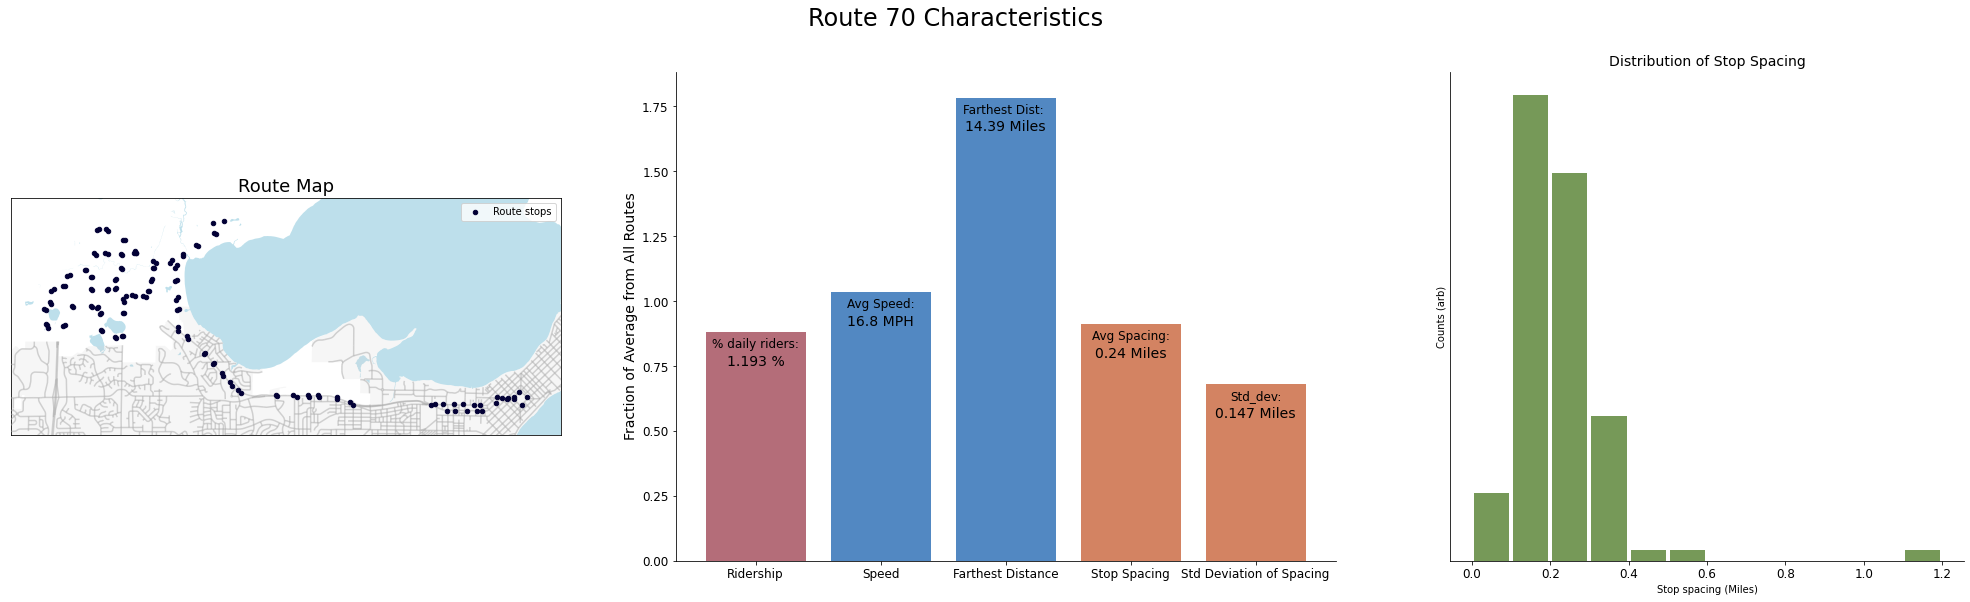

In [28]:
plotRouteCharacteristics_colors(70)

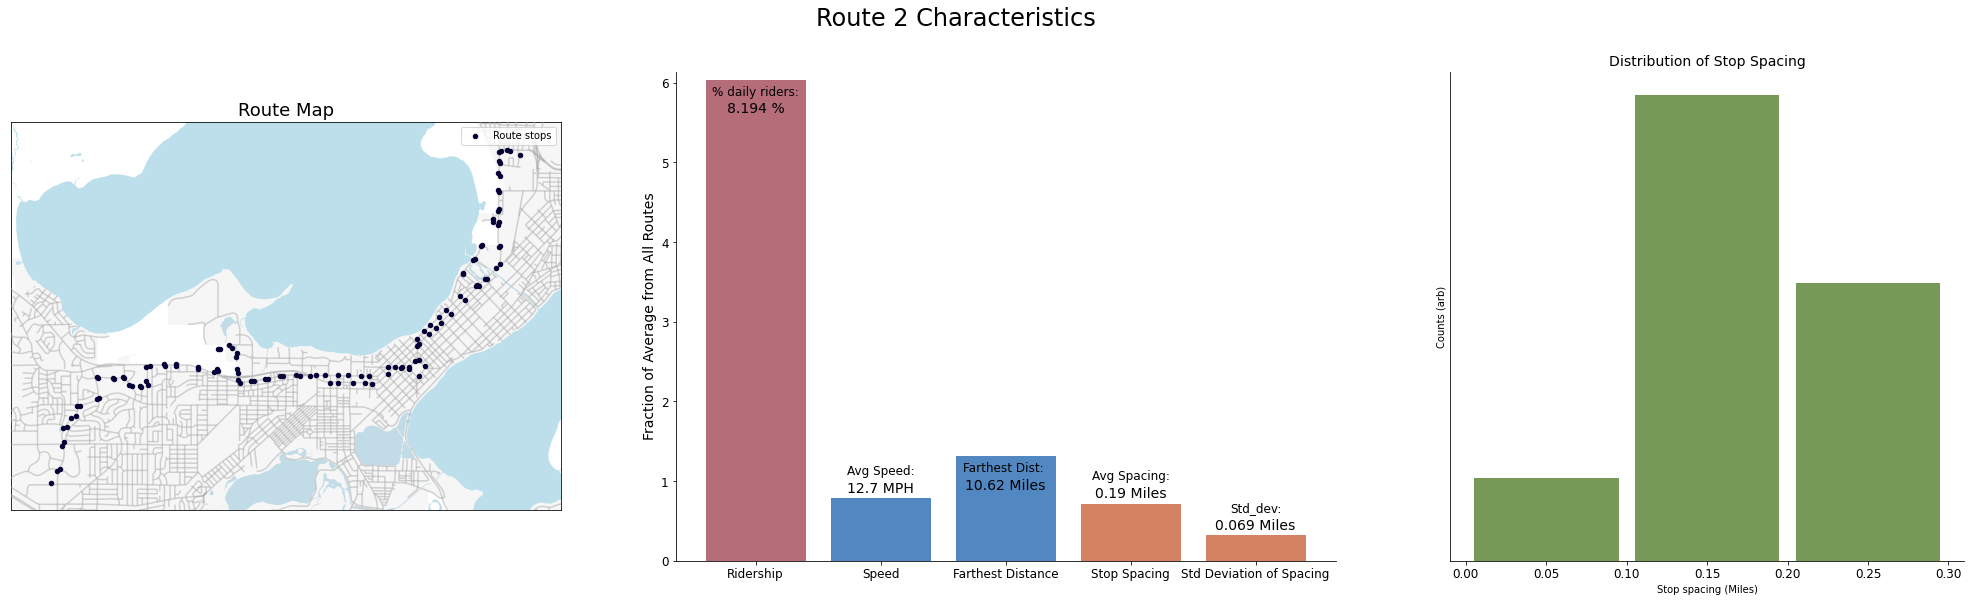

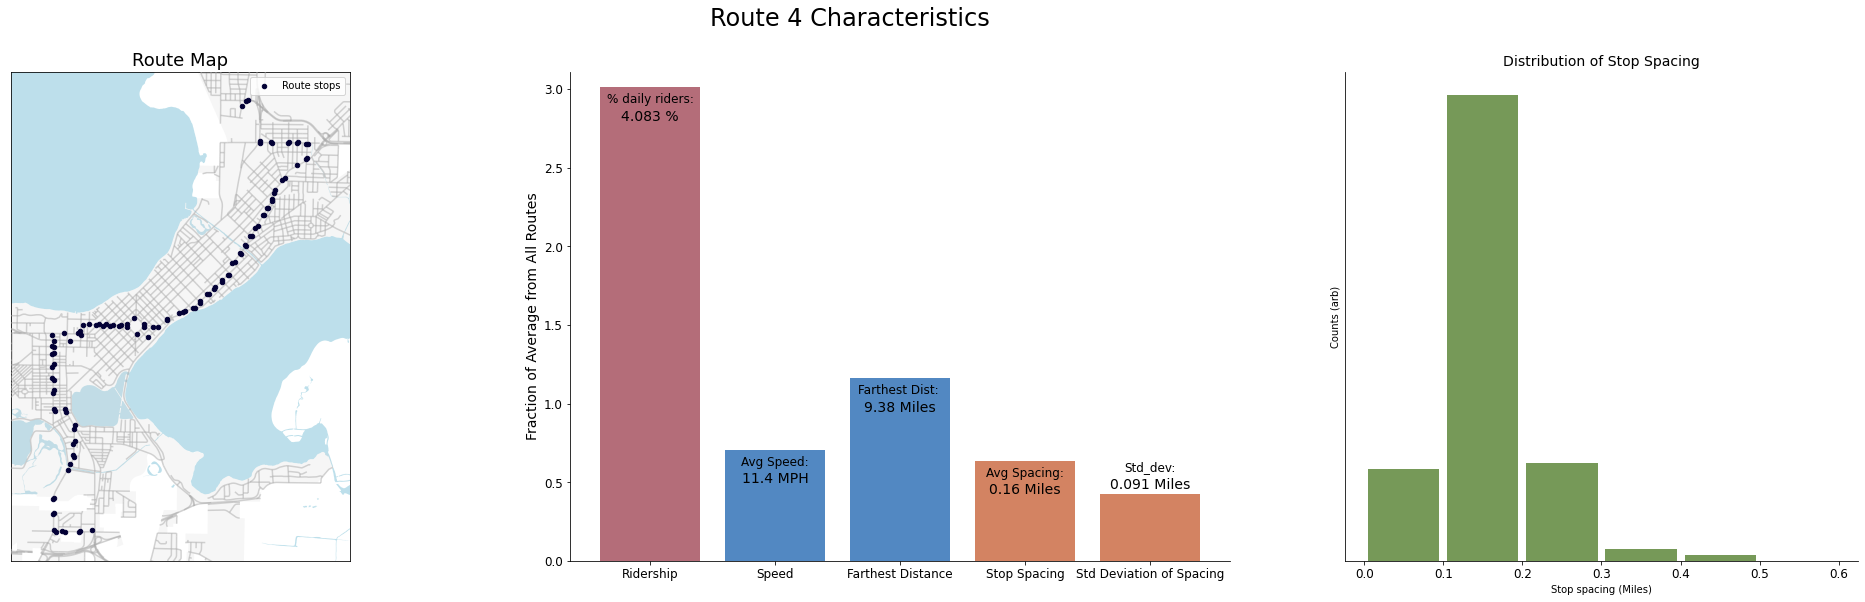

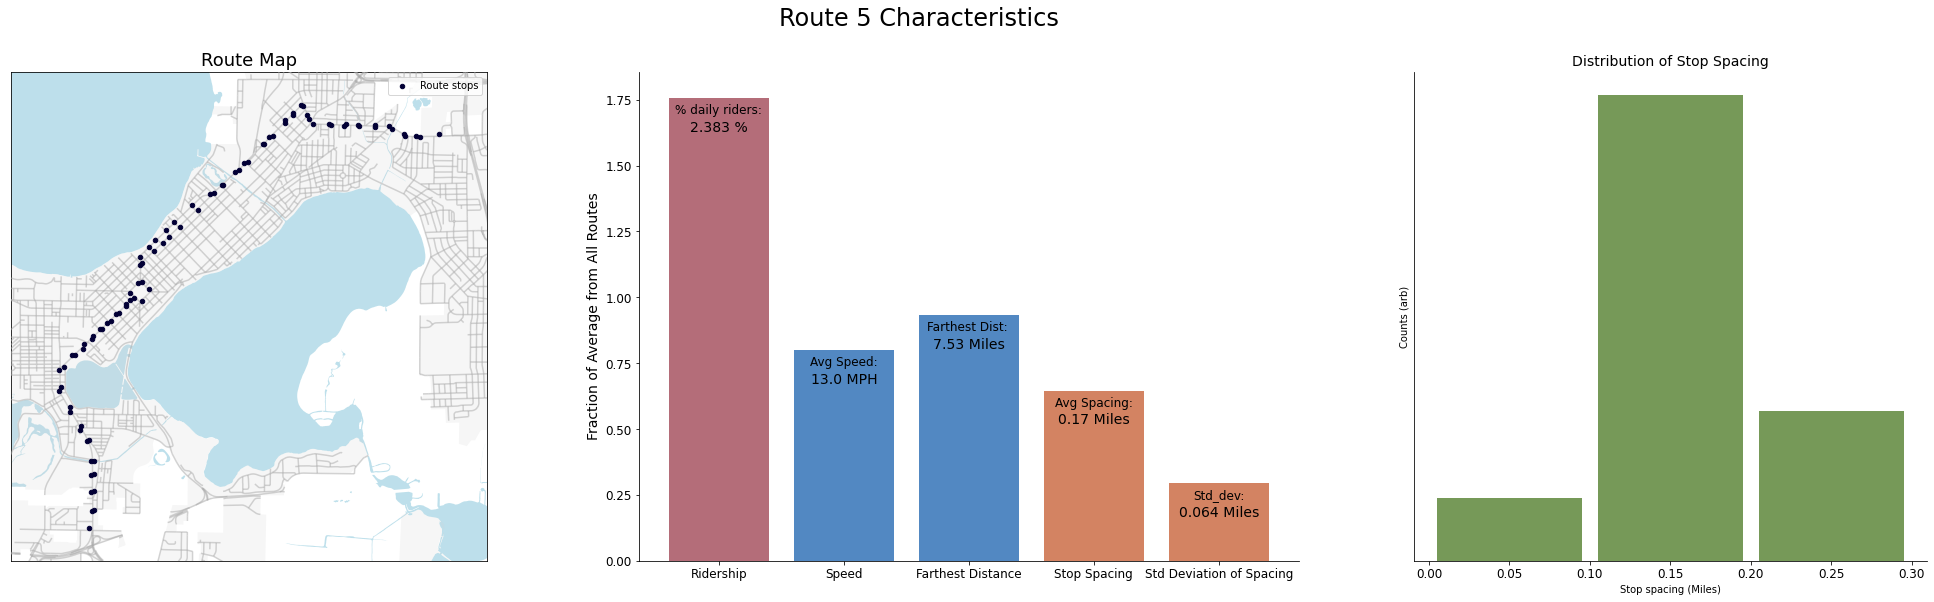

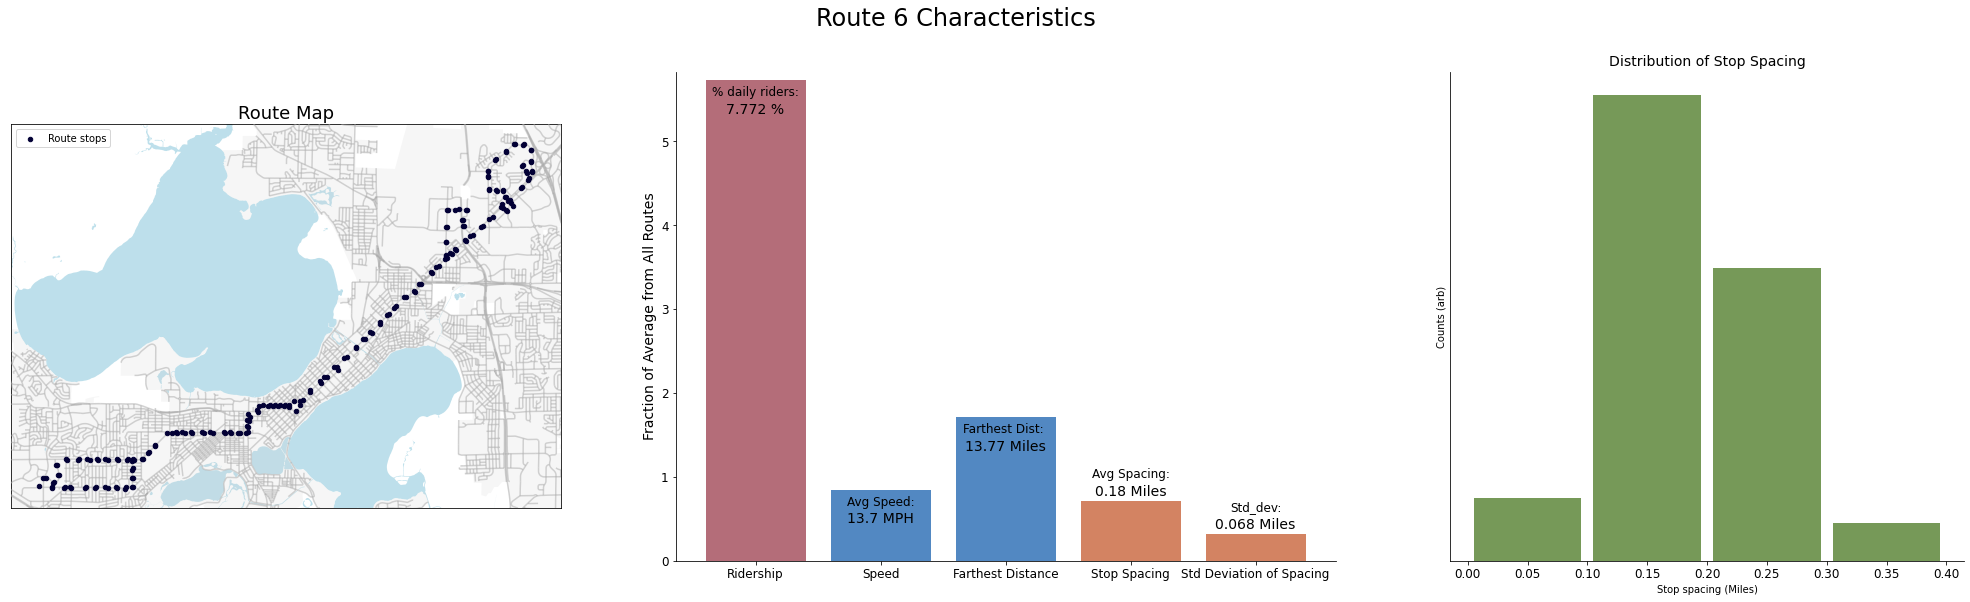

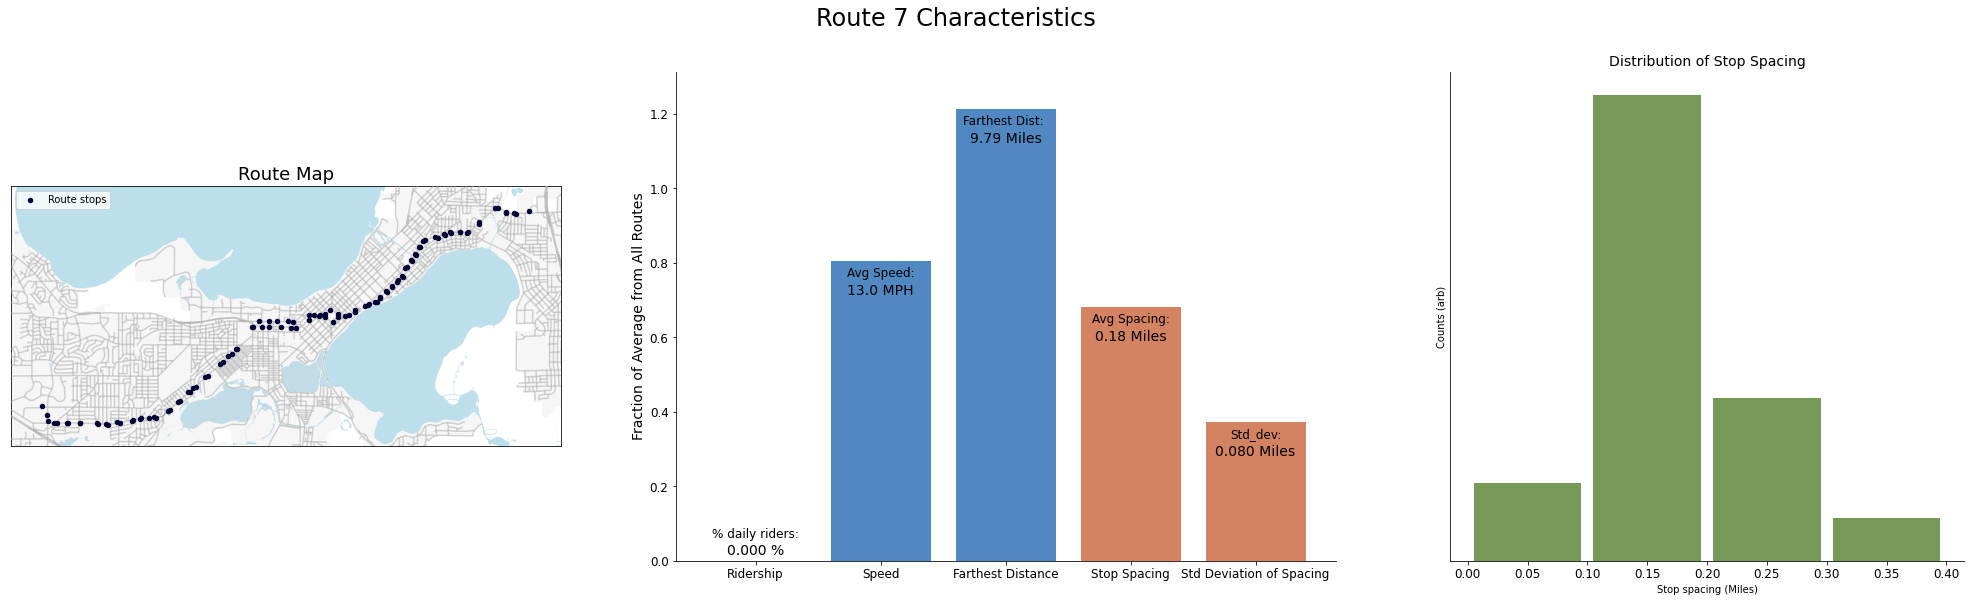

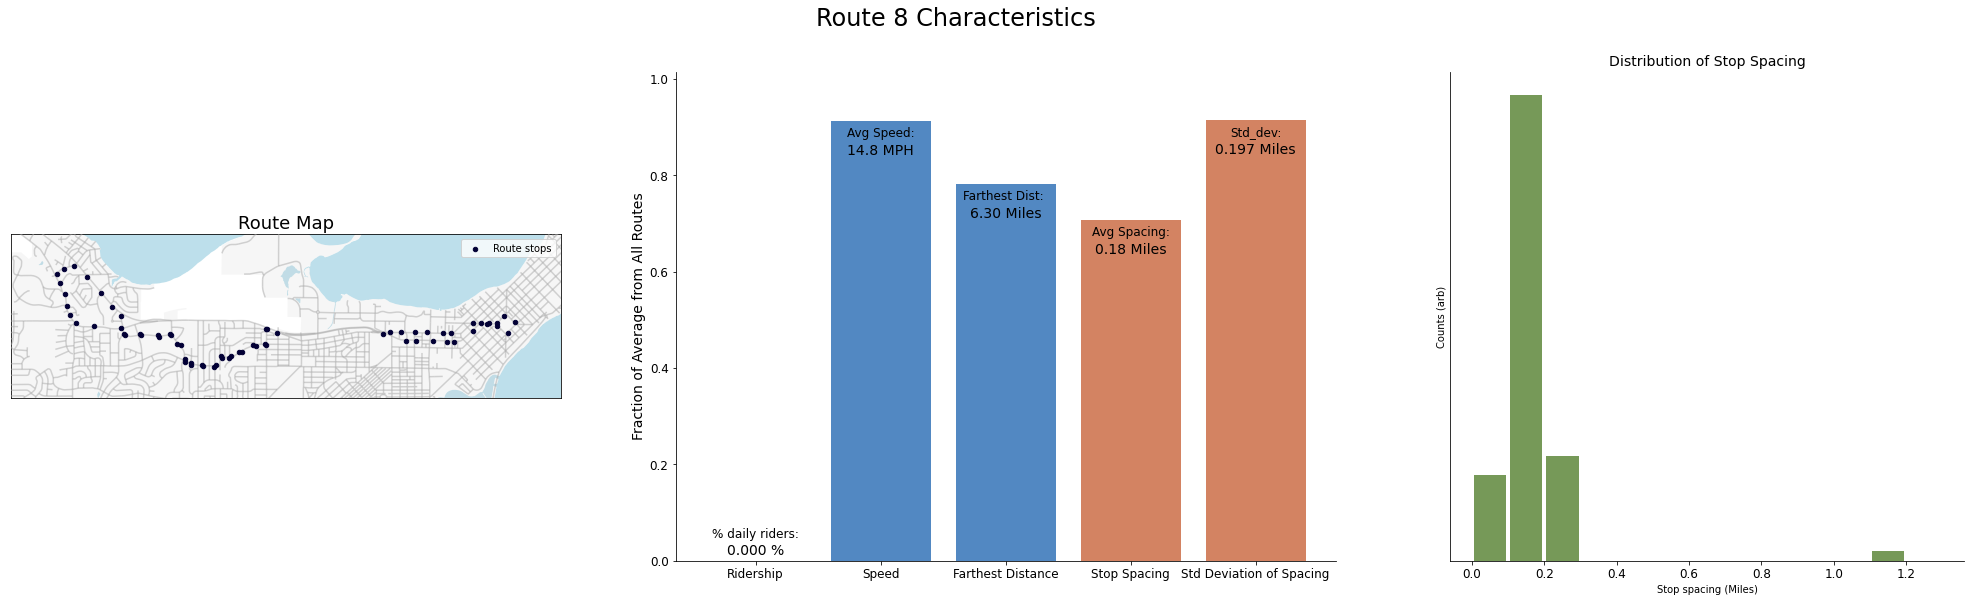

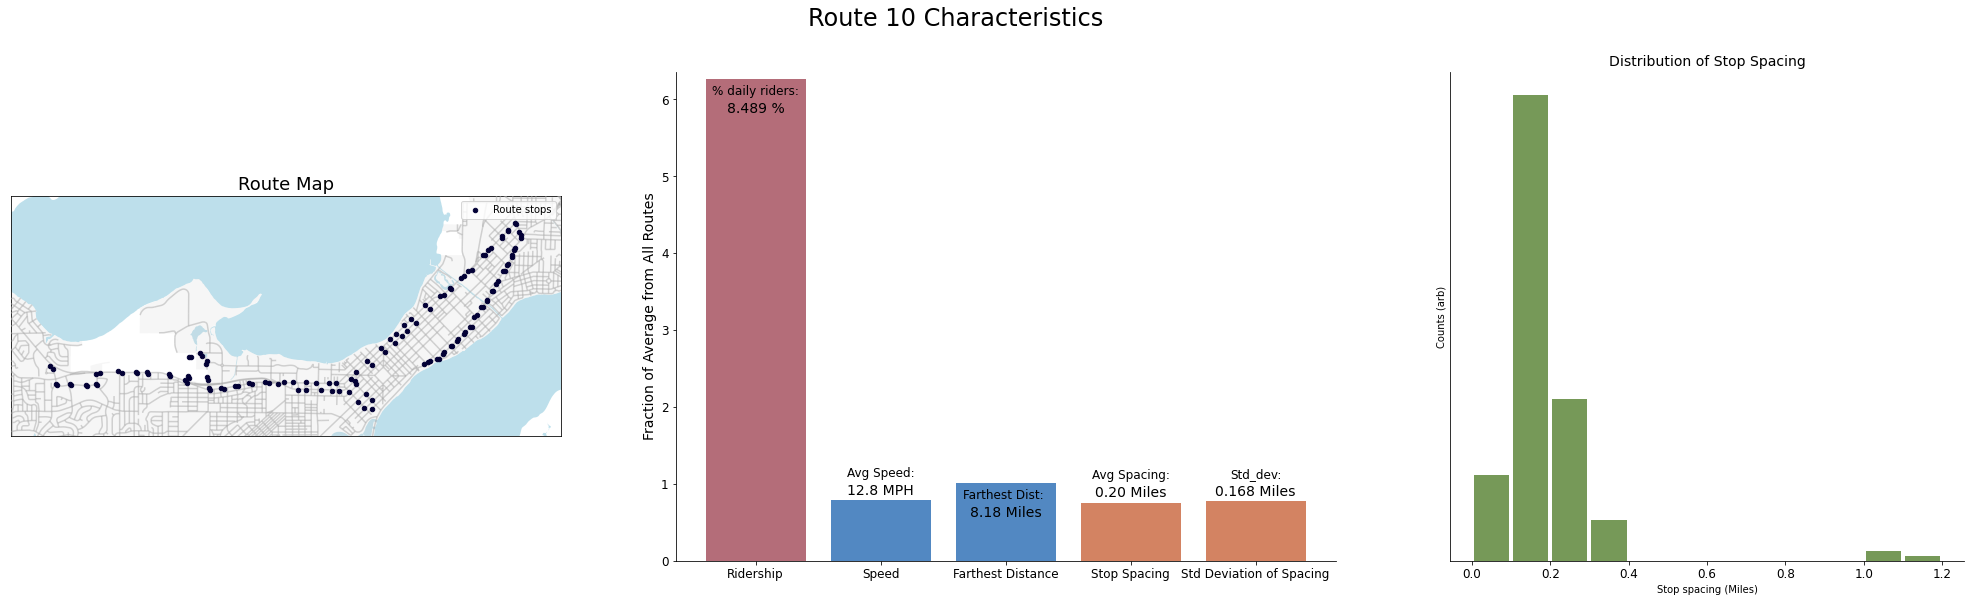

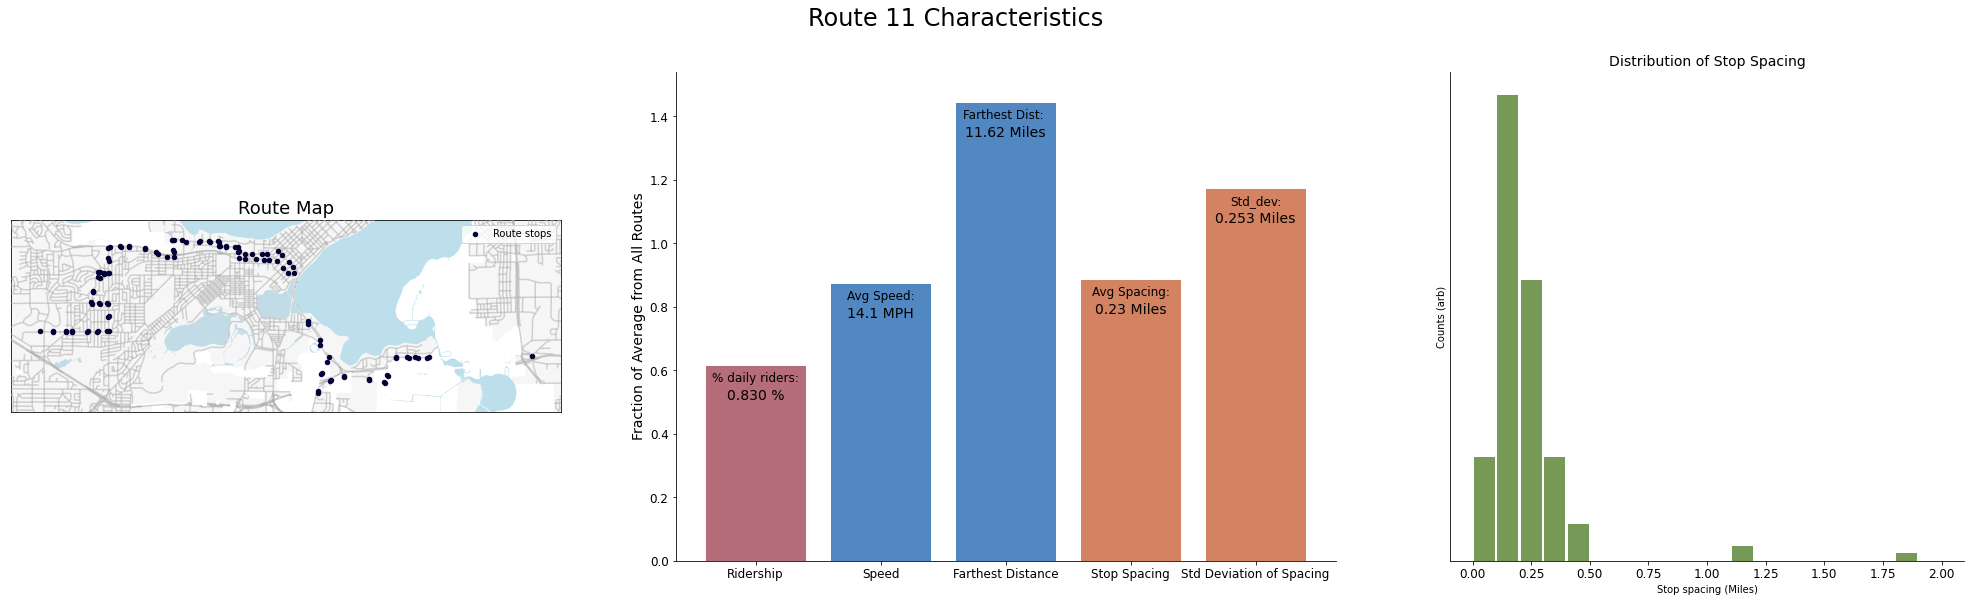

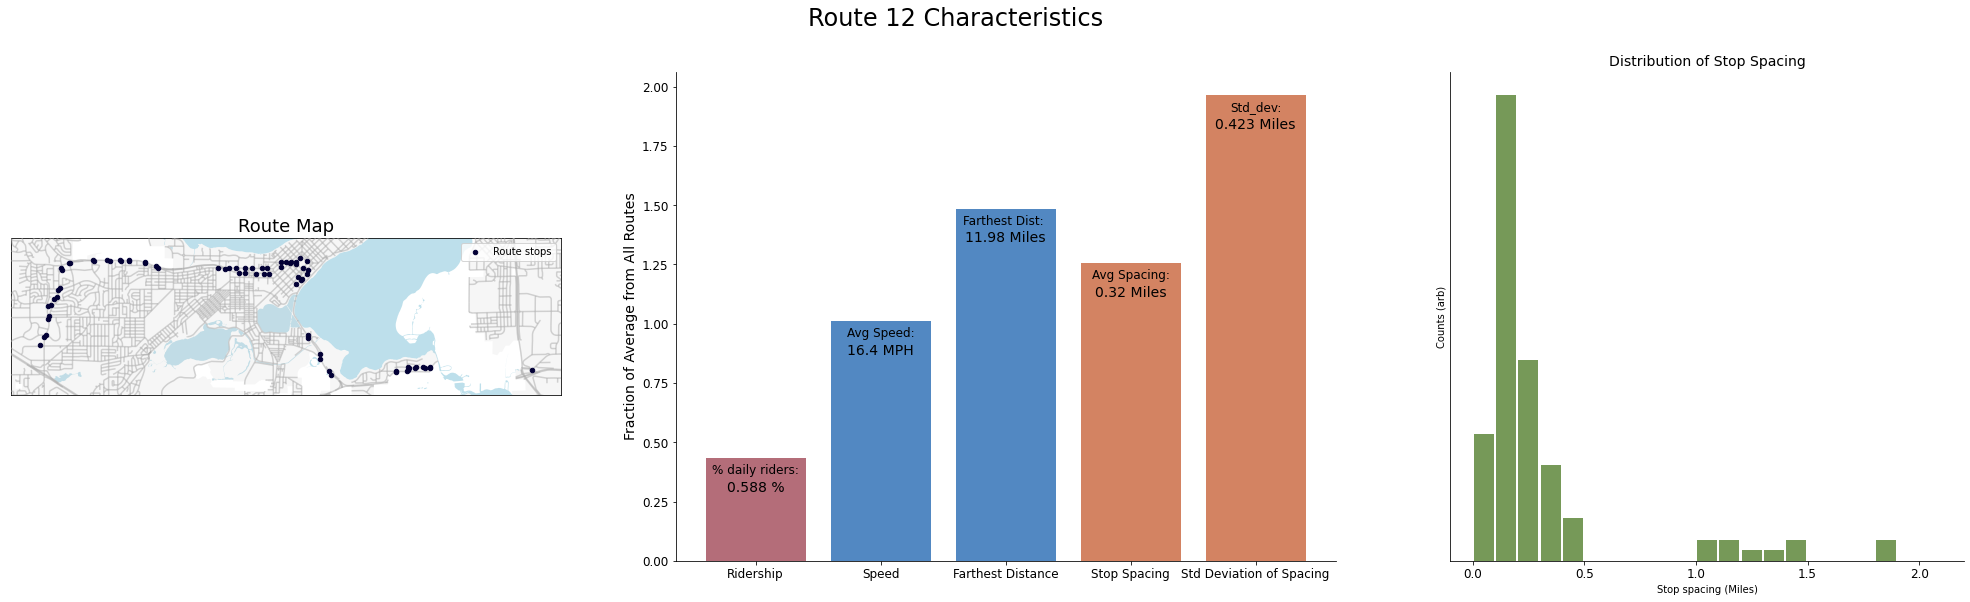

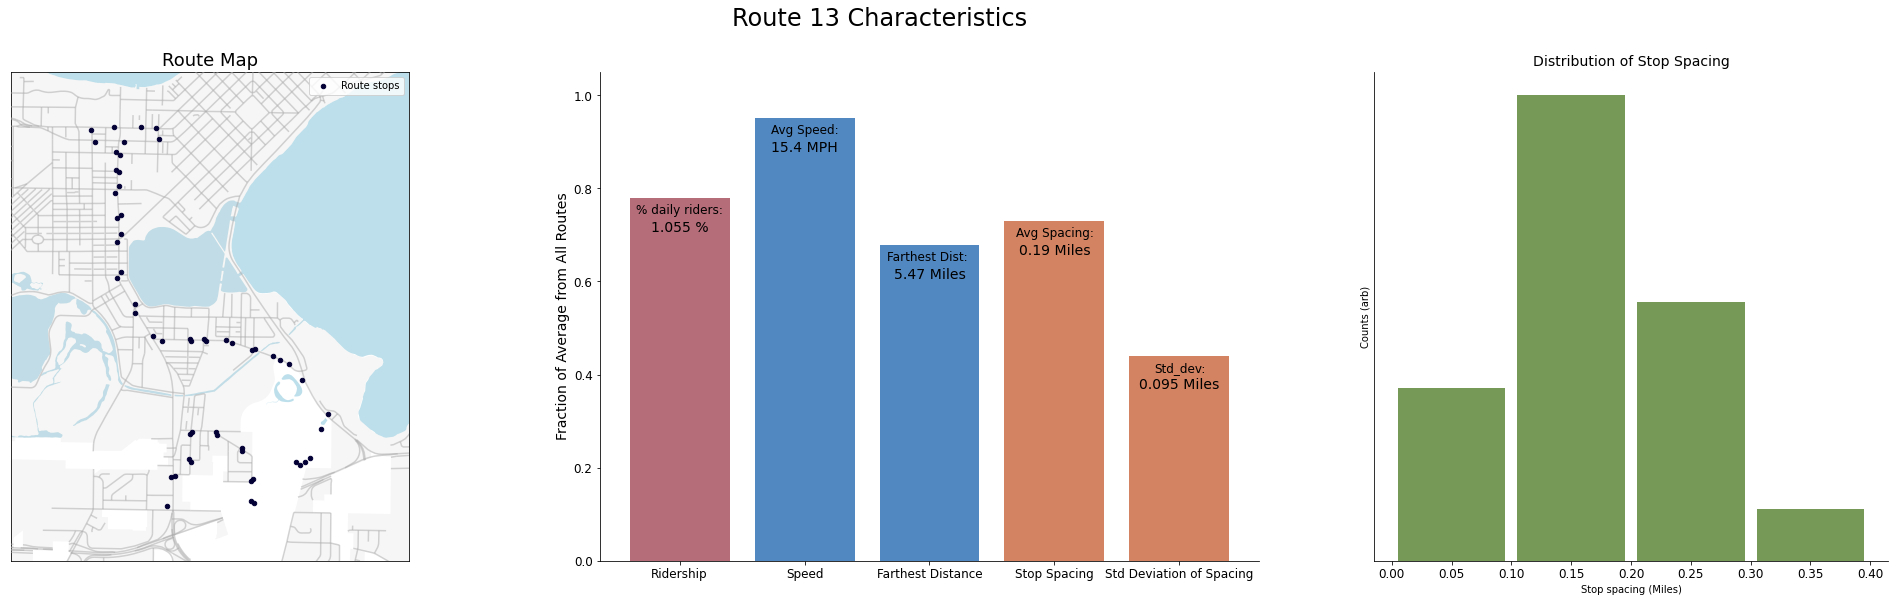

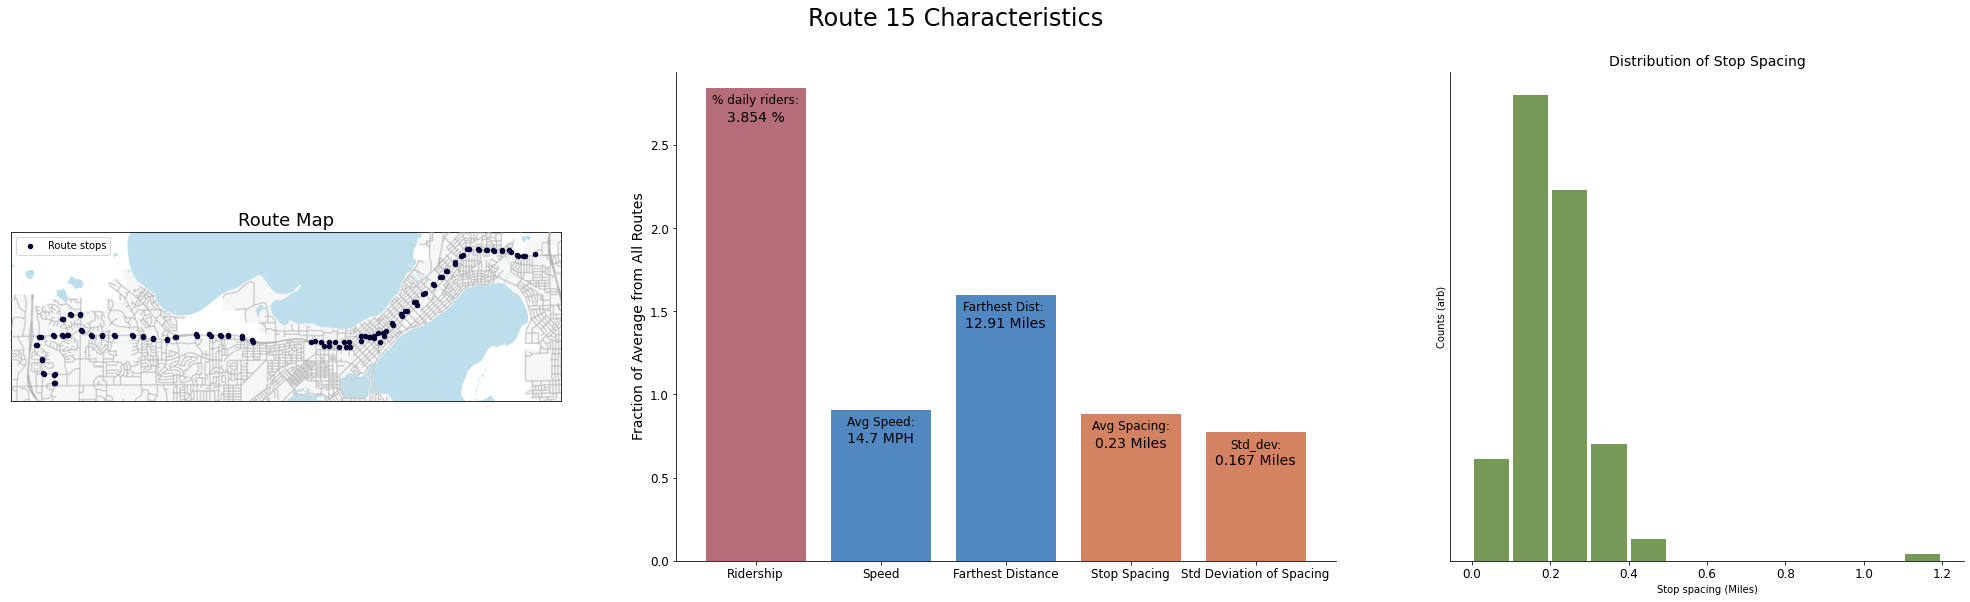

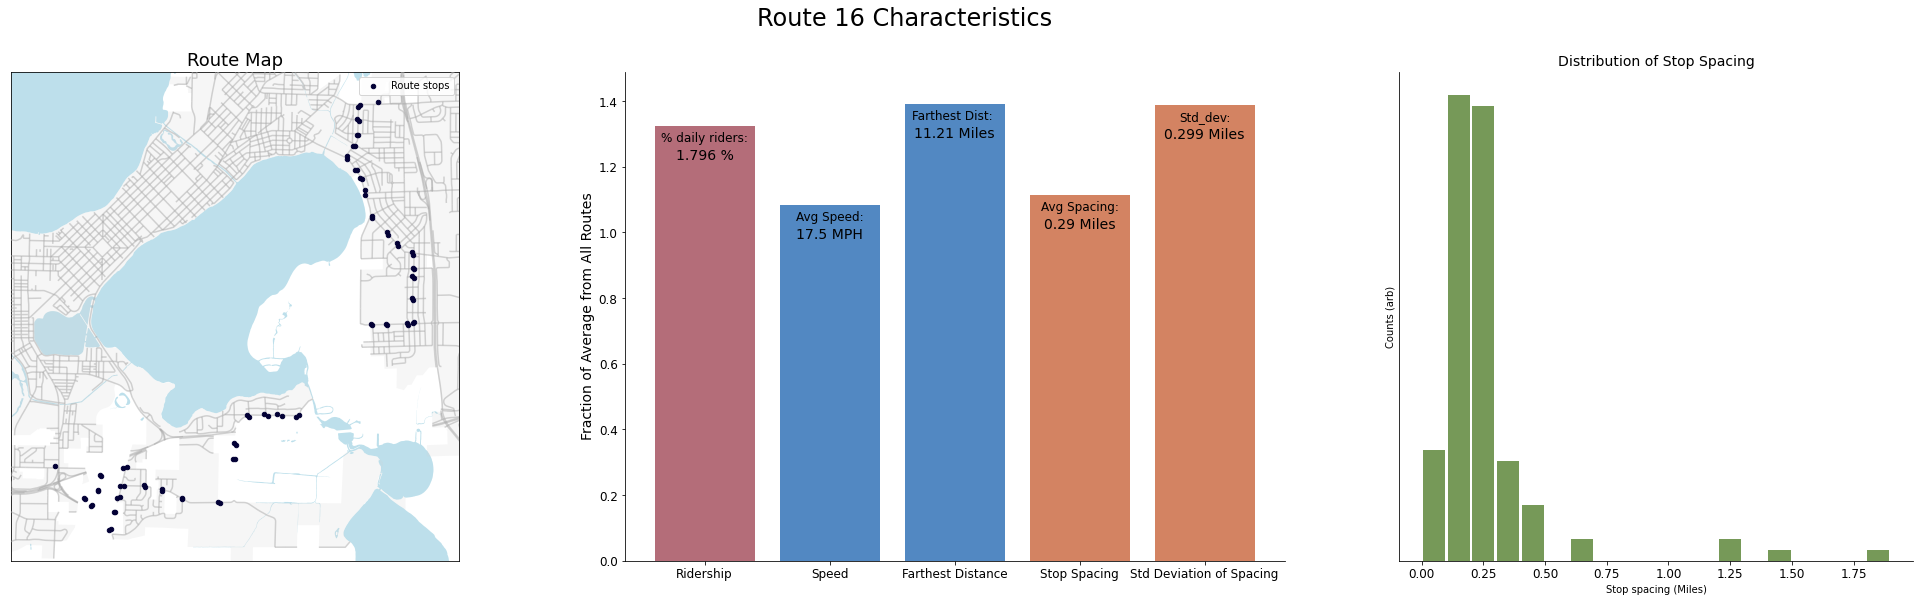

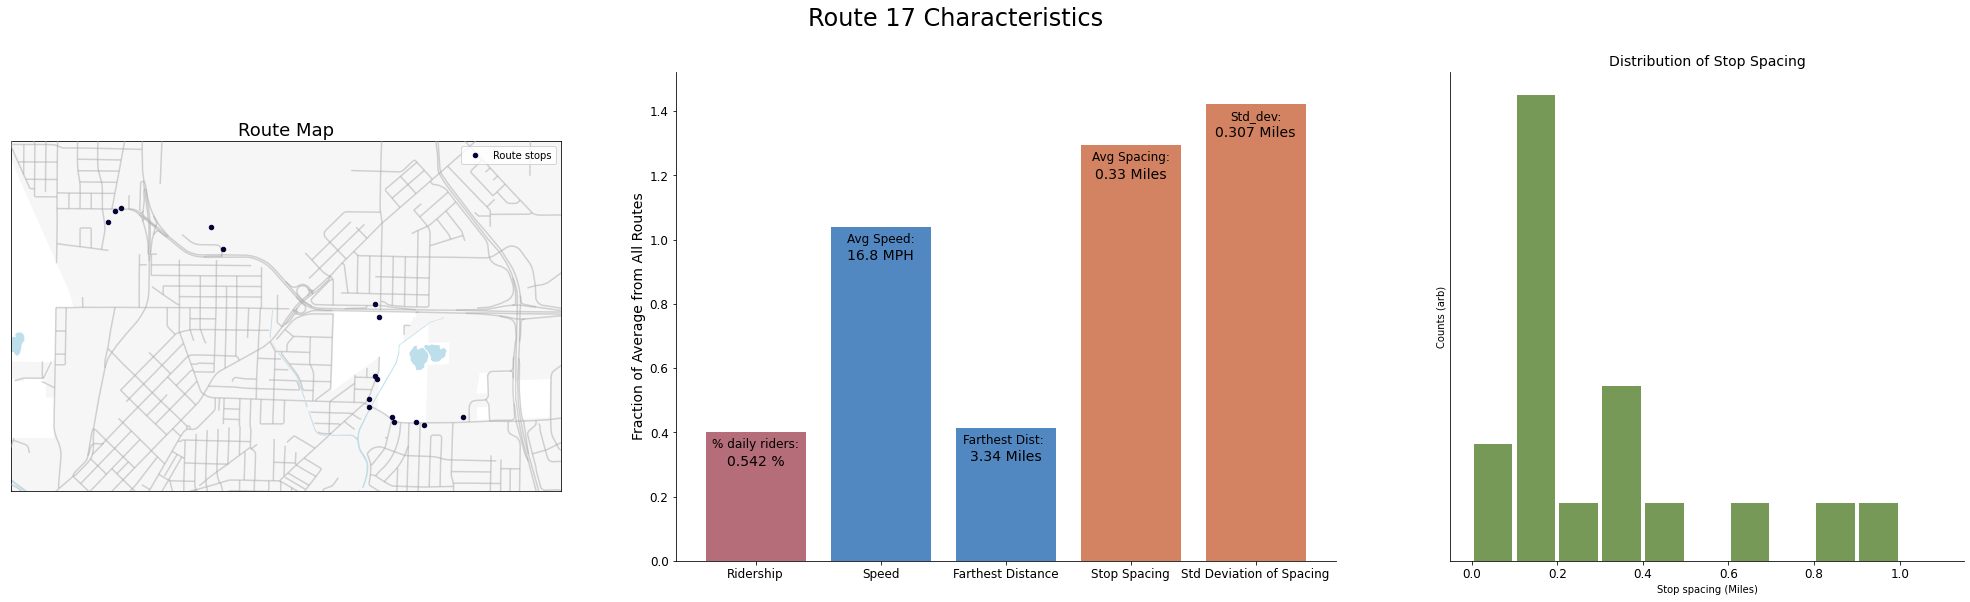

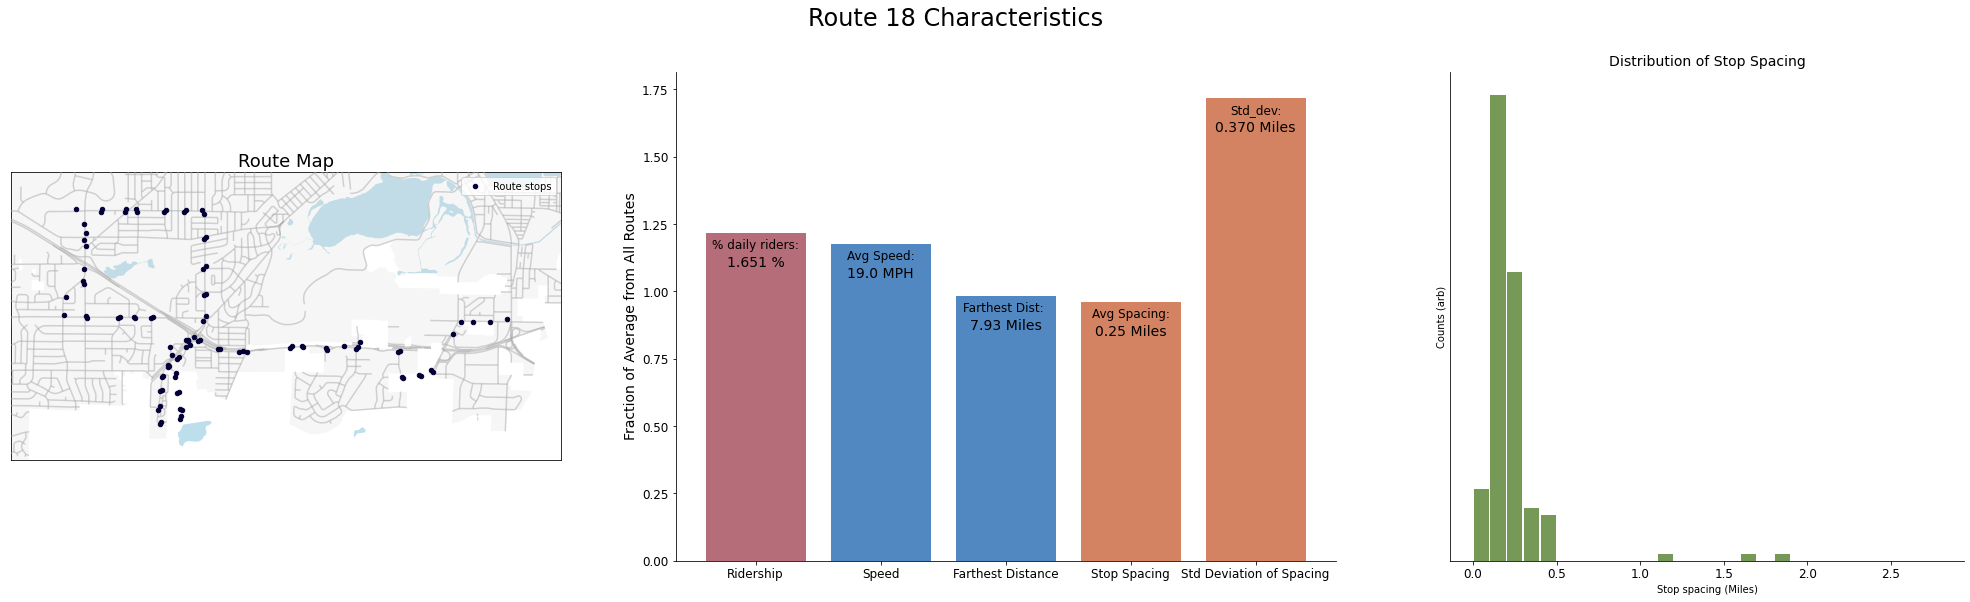

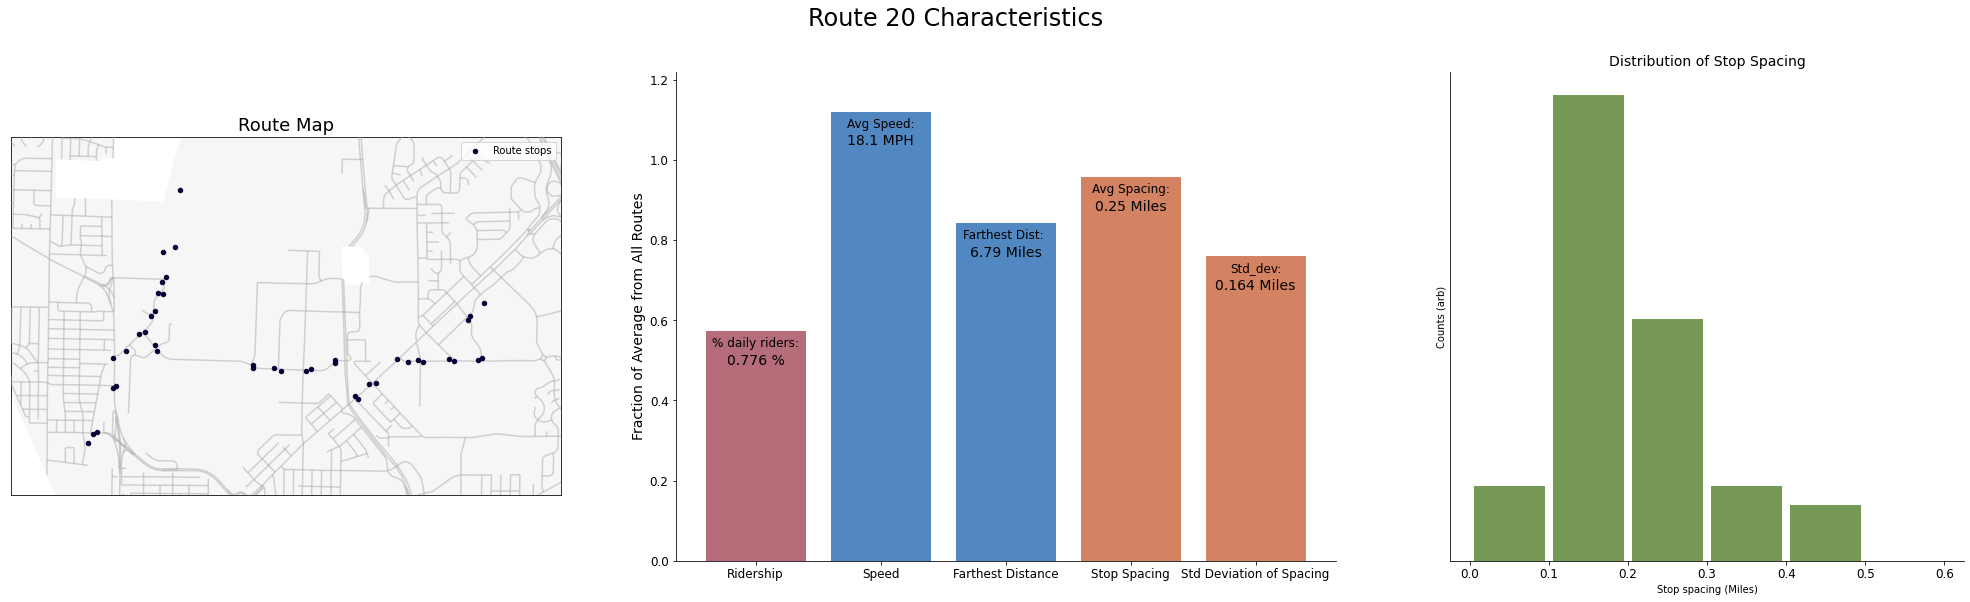

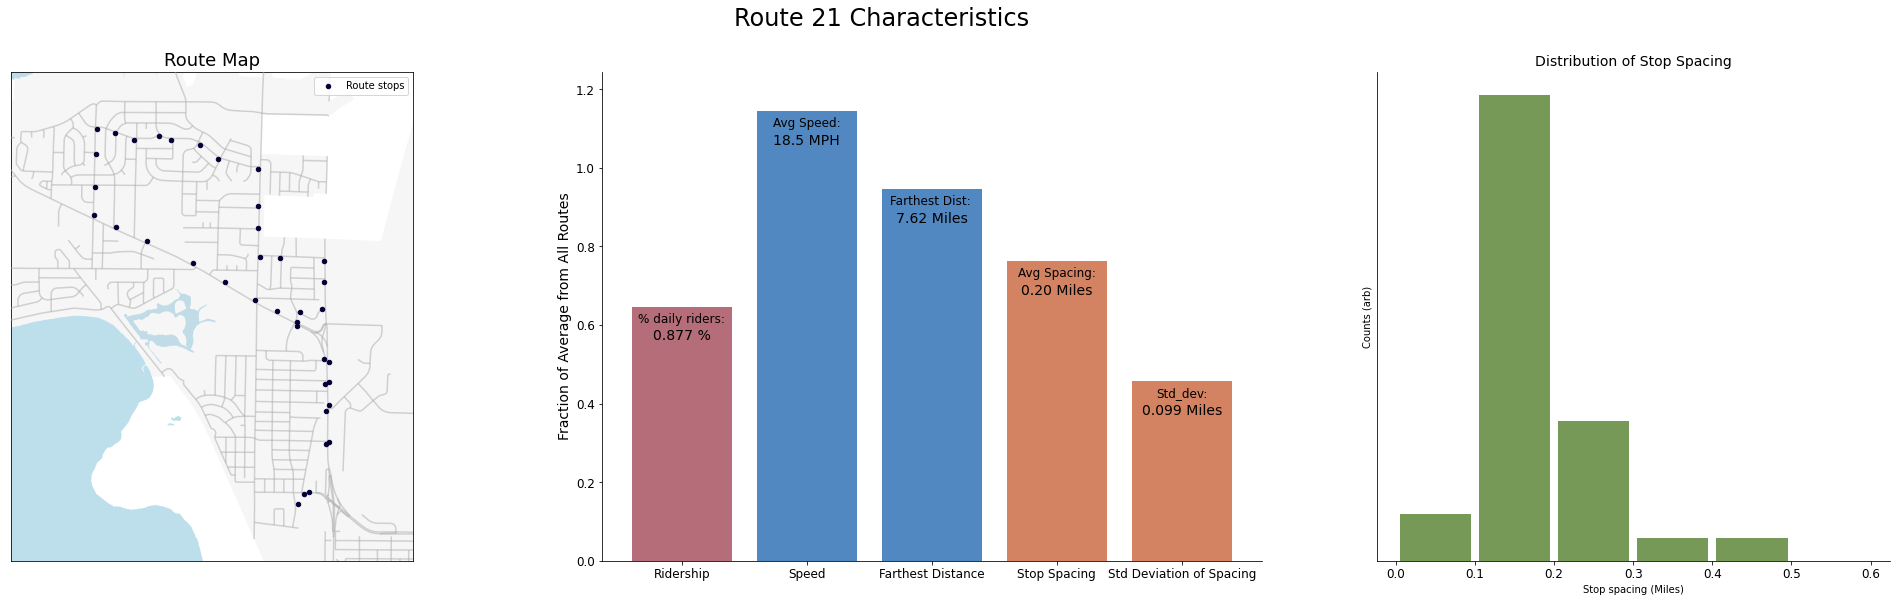

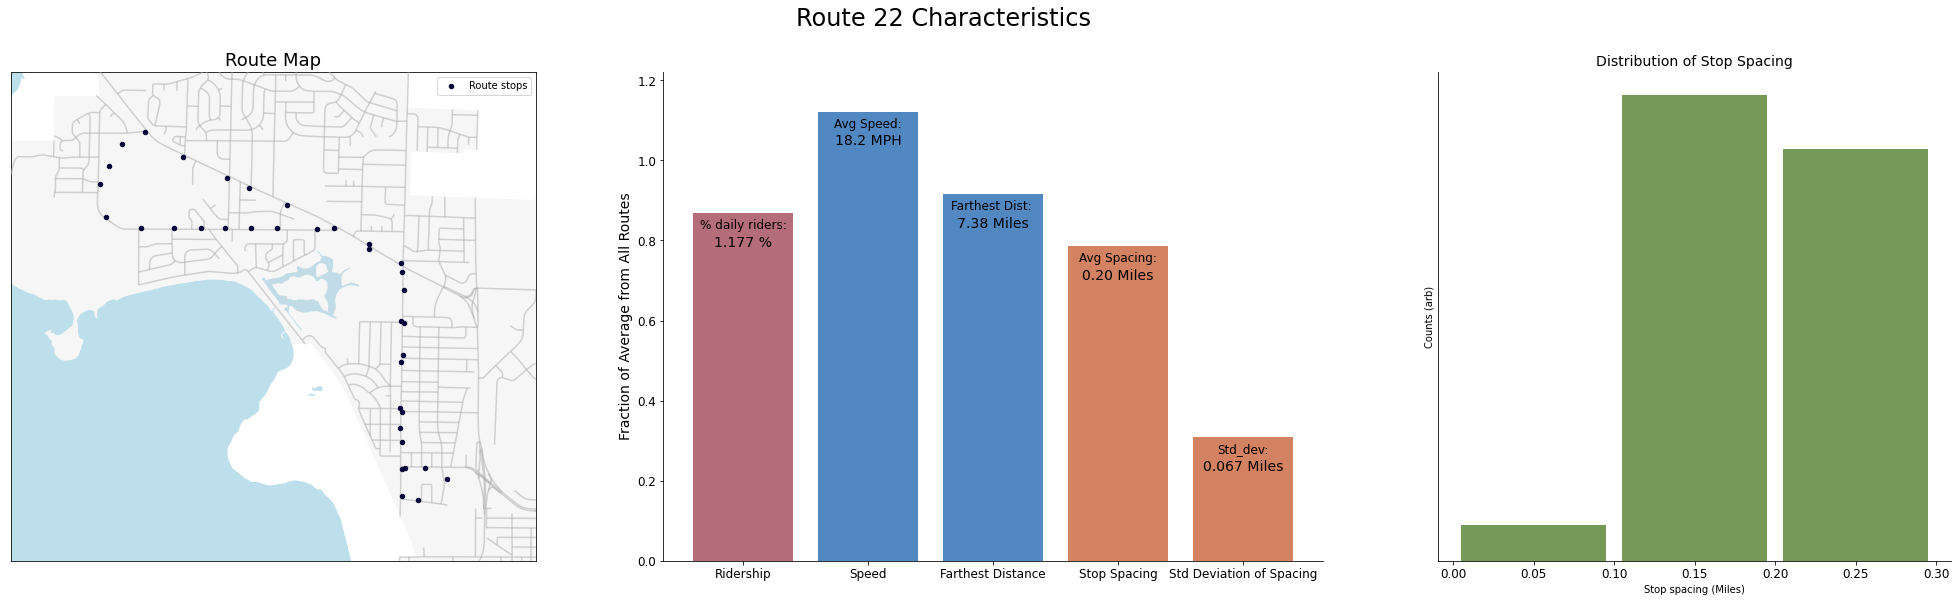

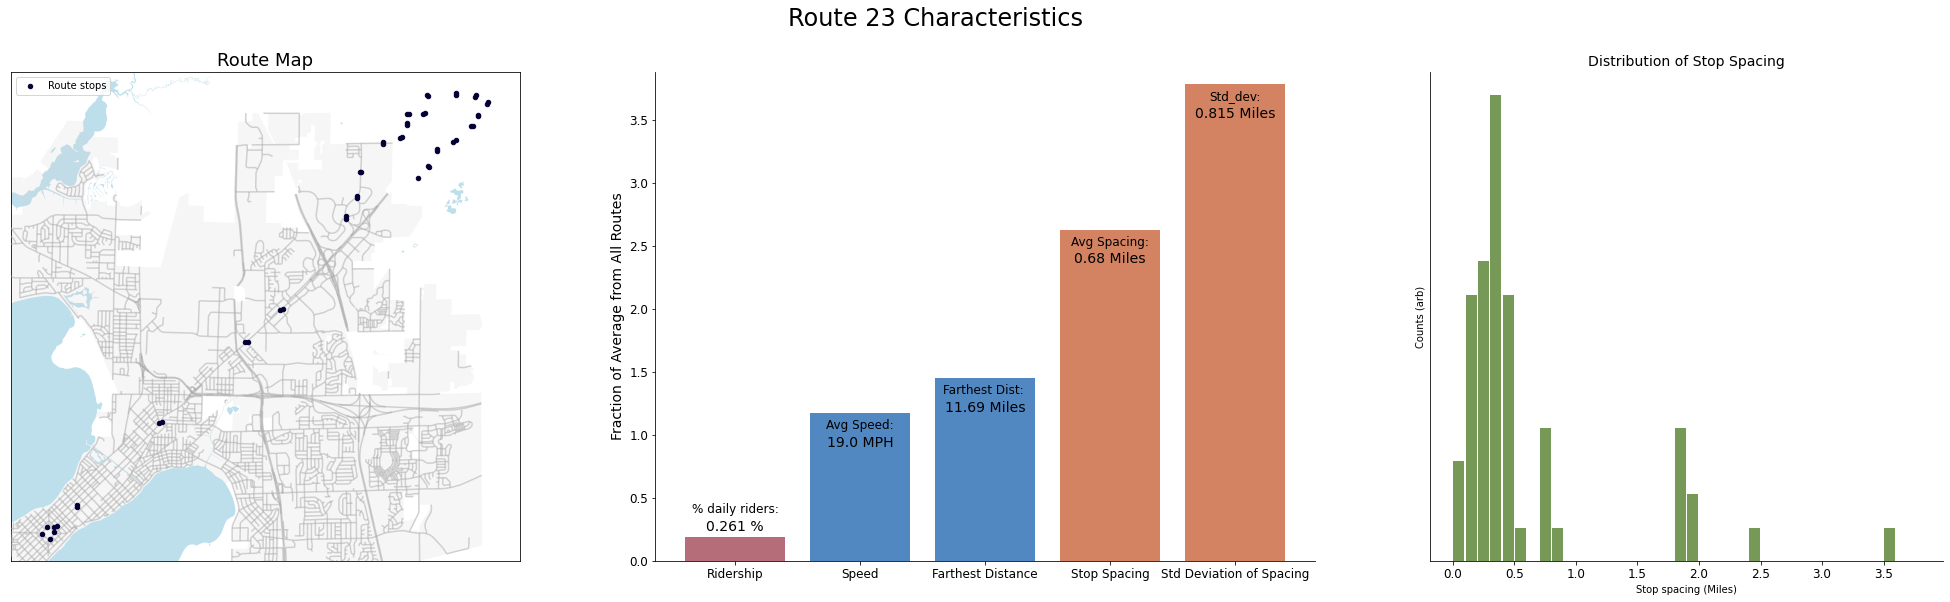

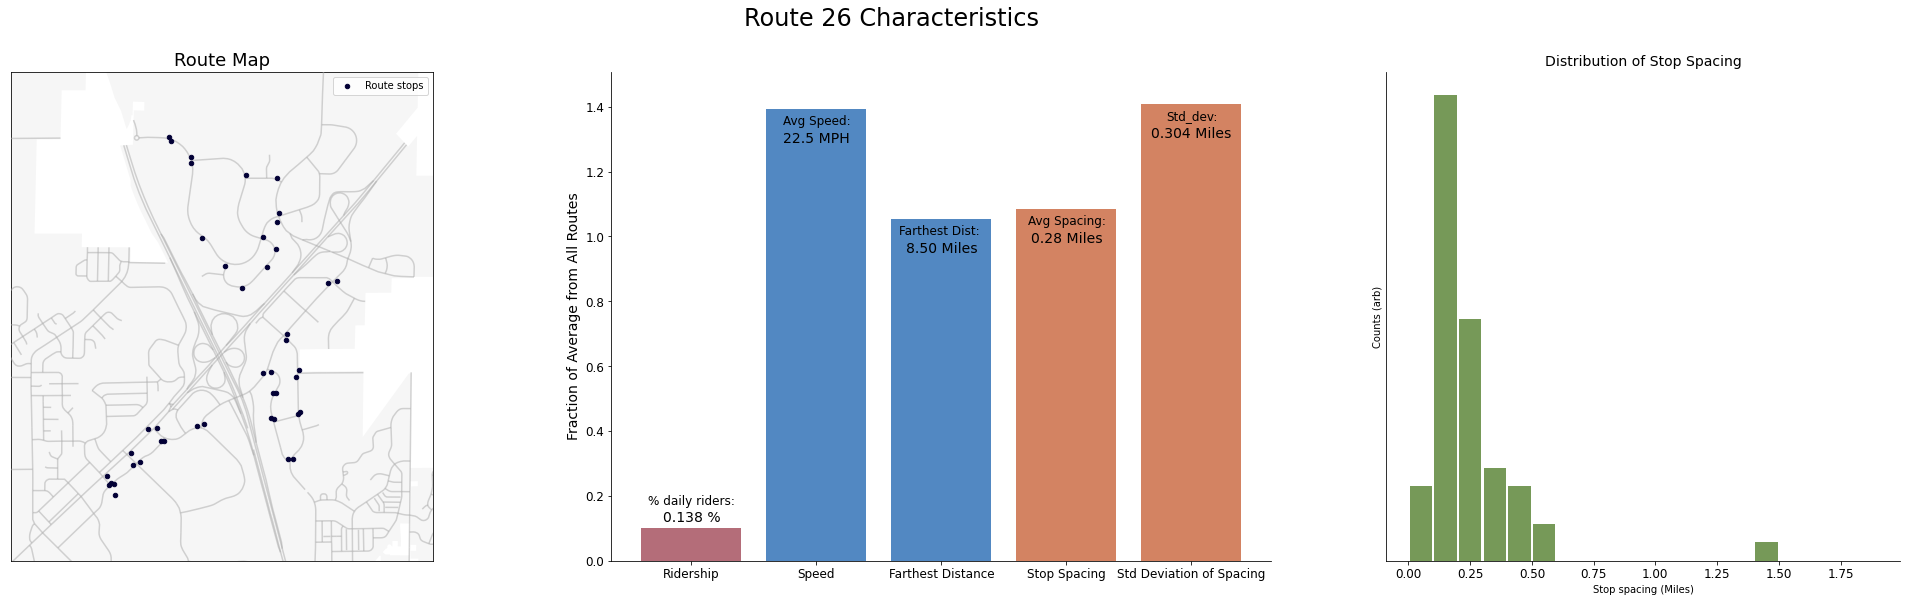

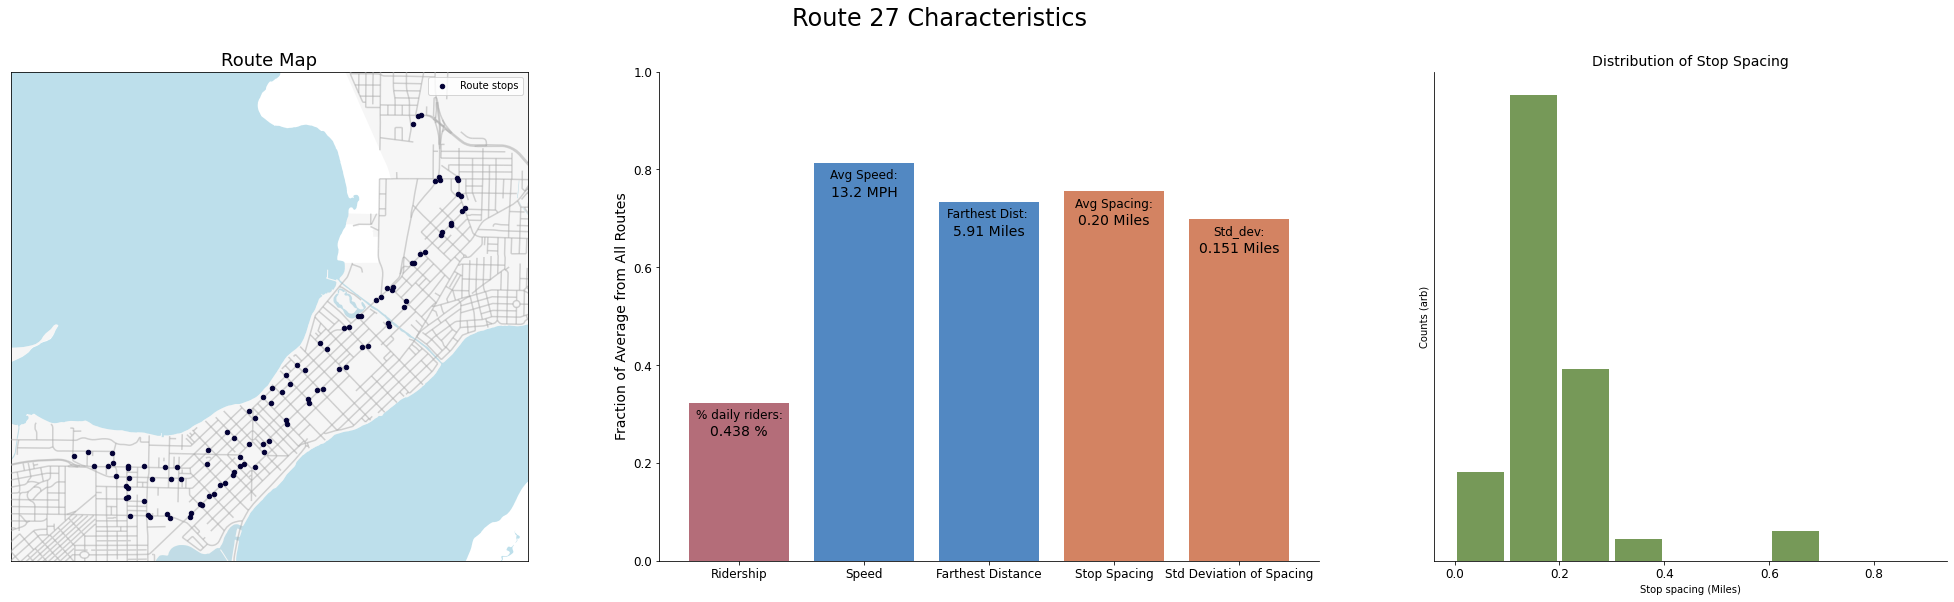

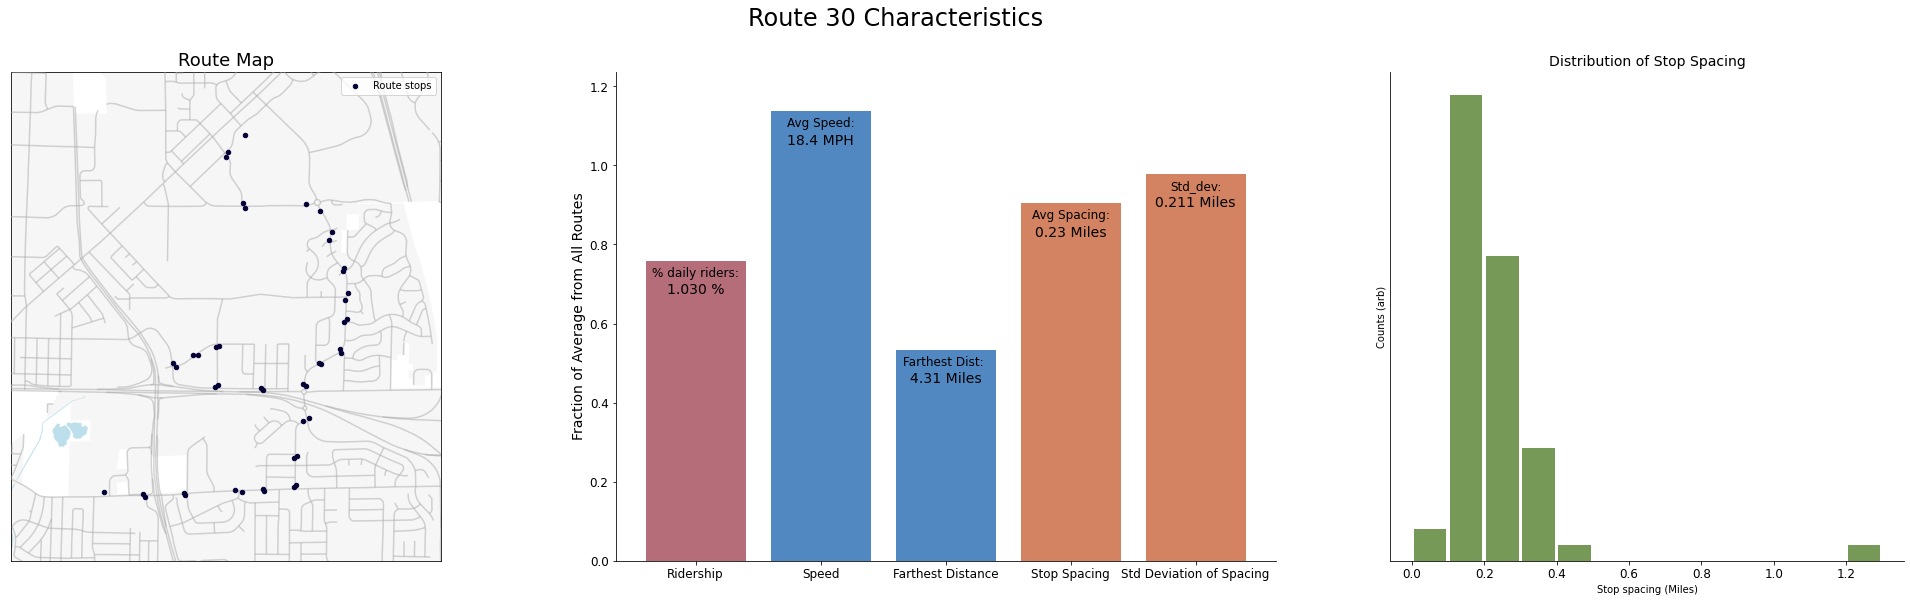

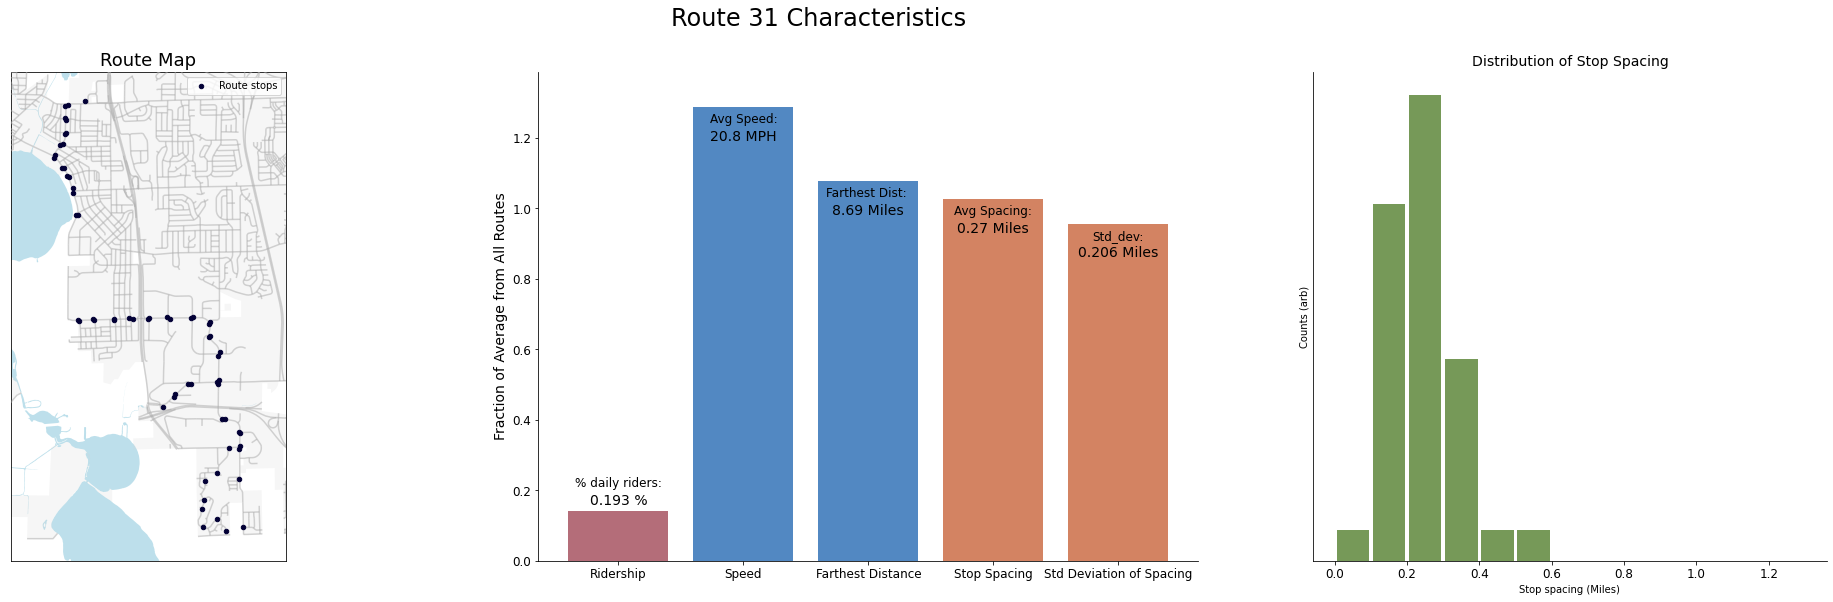

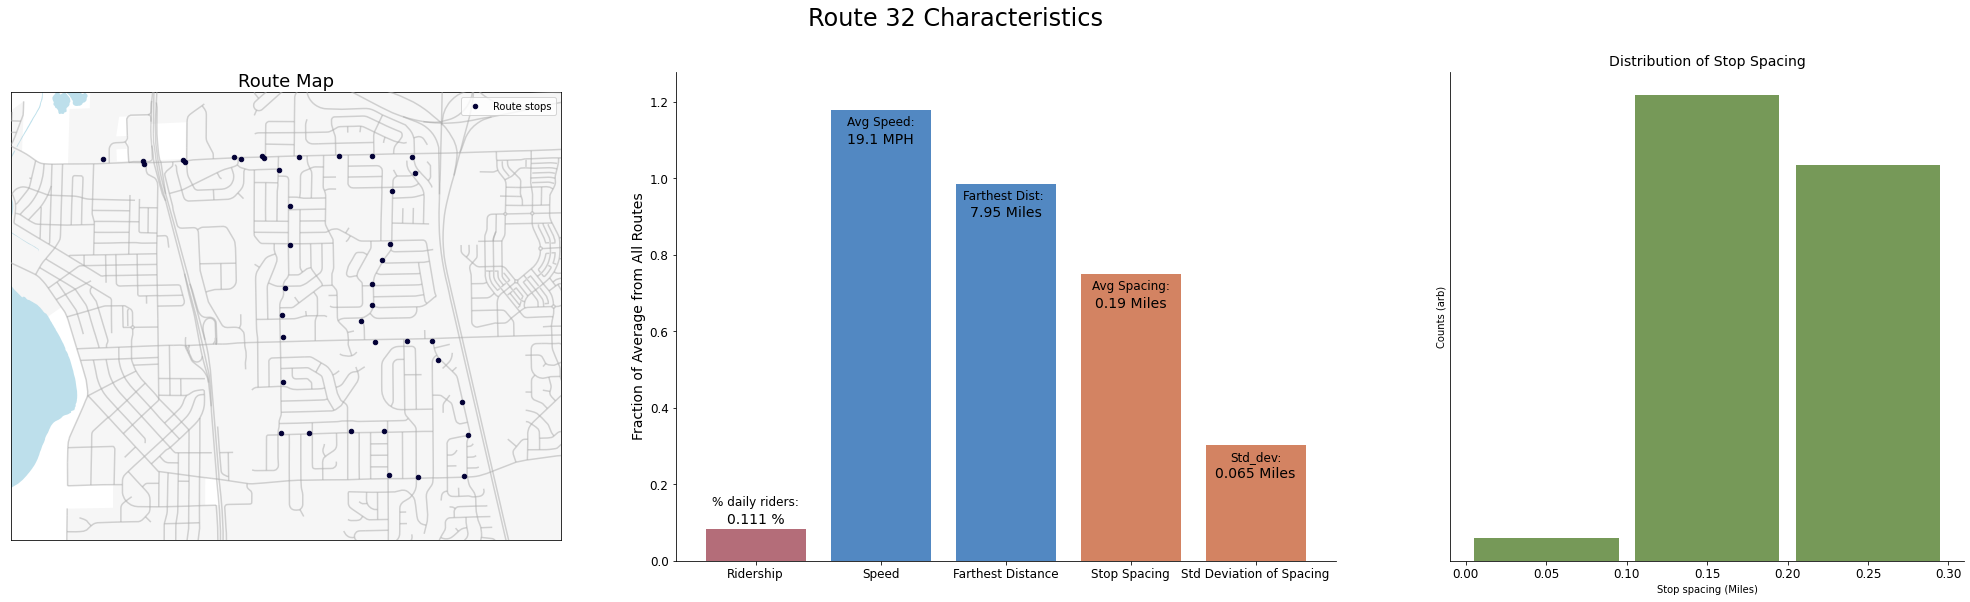

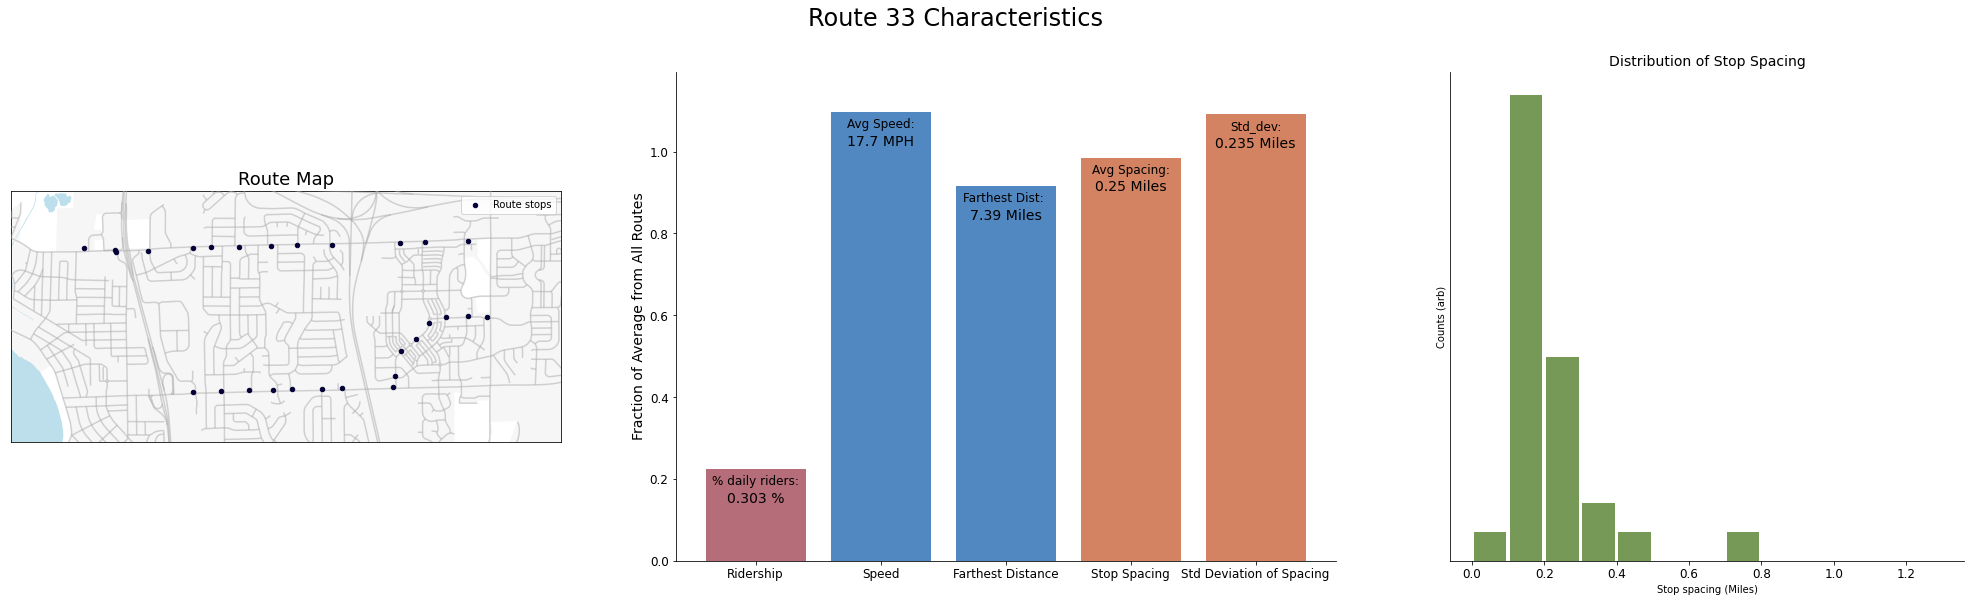

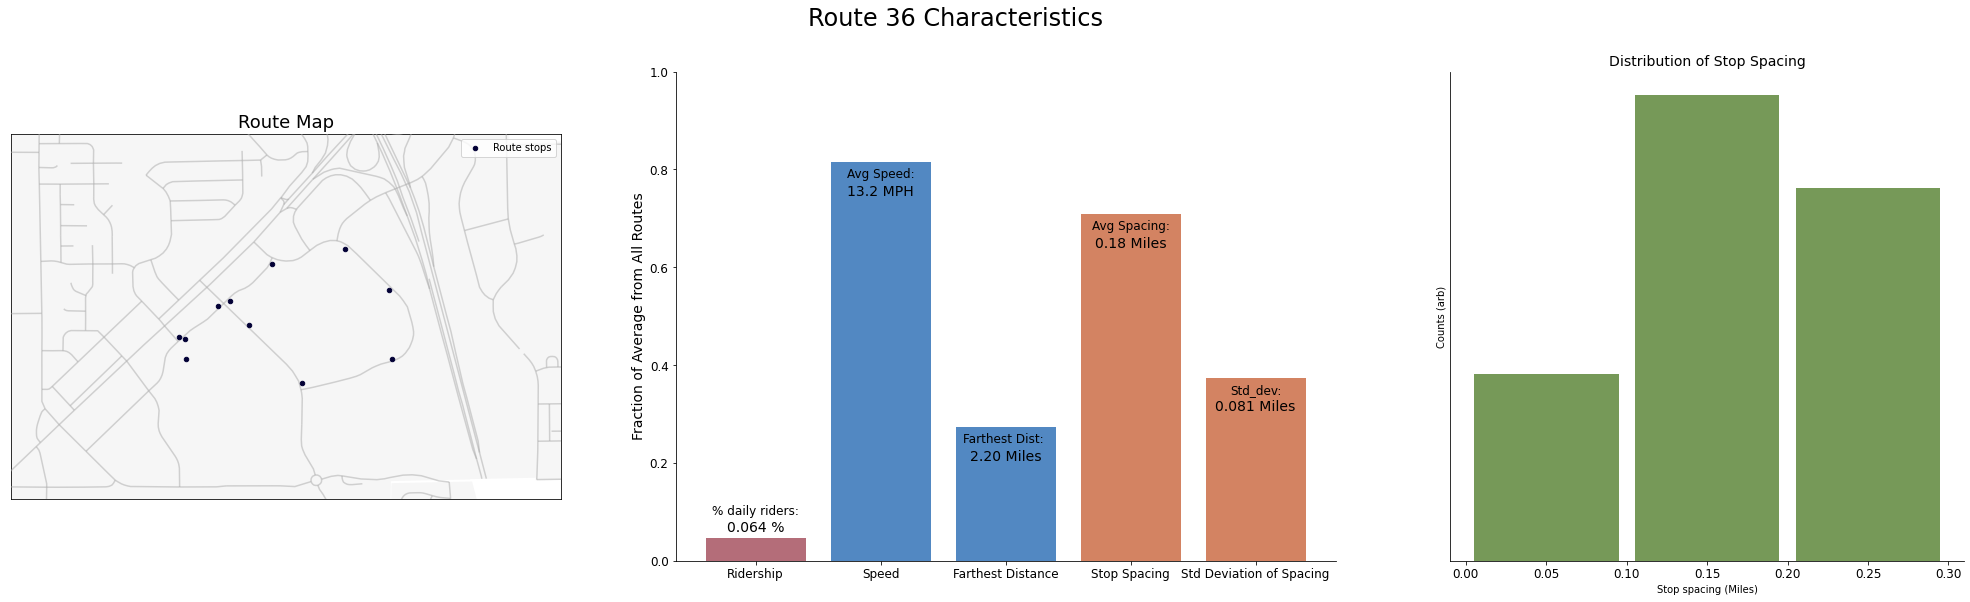

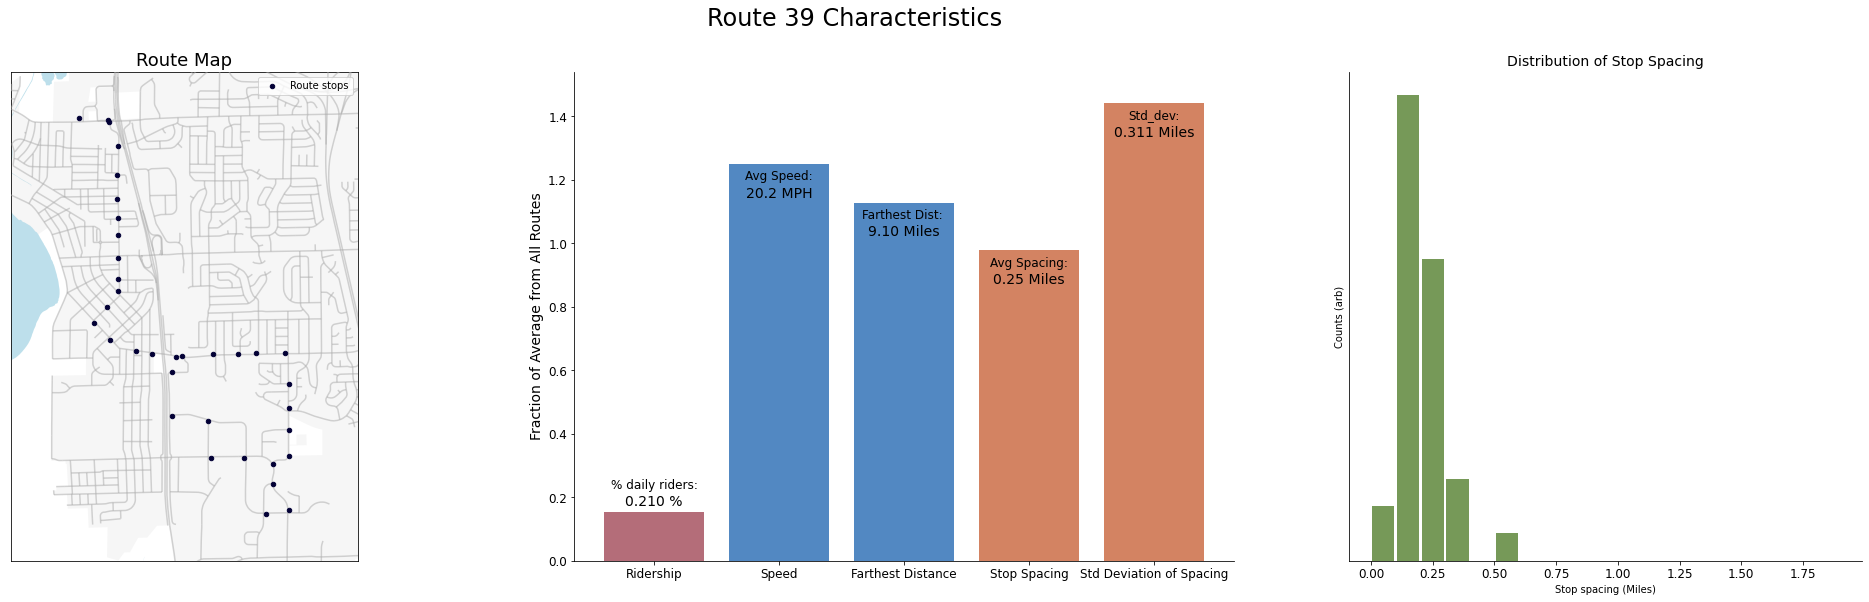

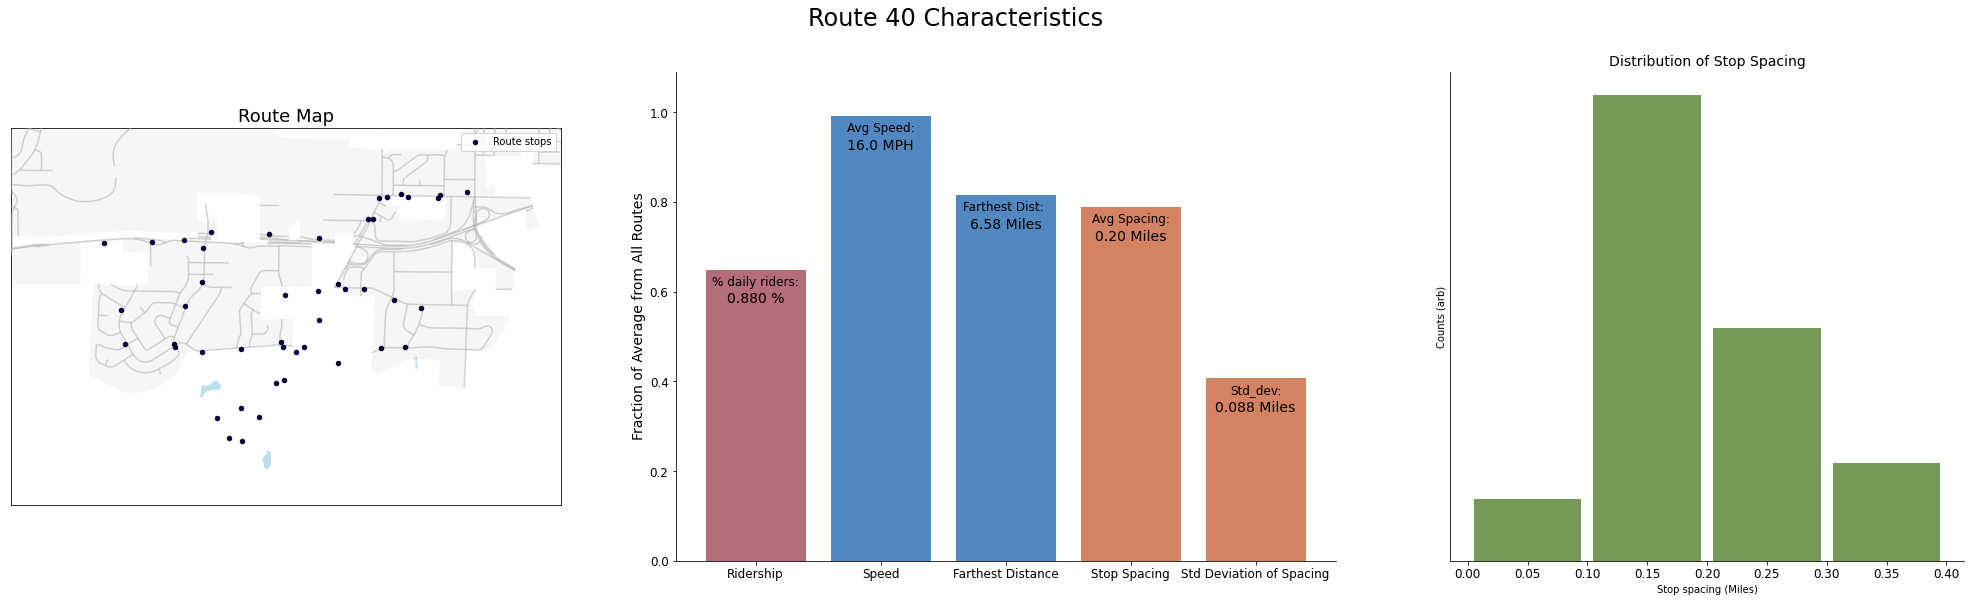

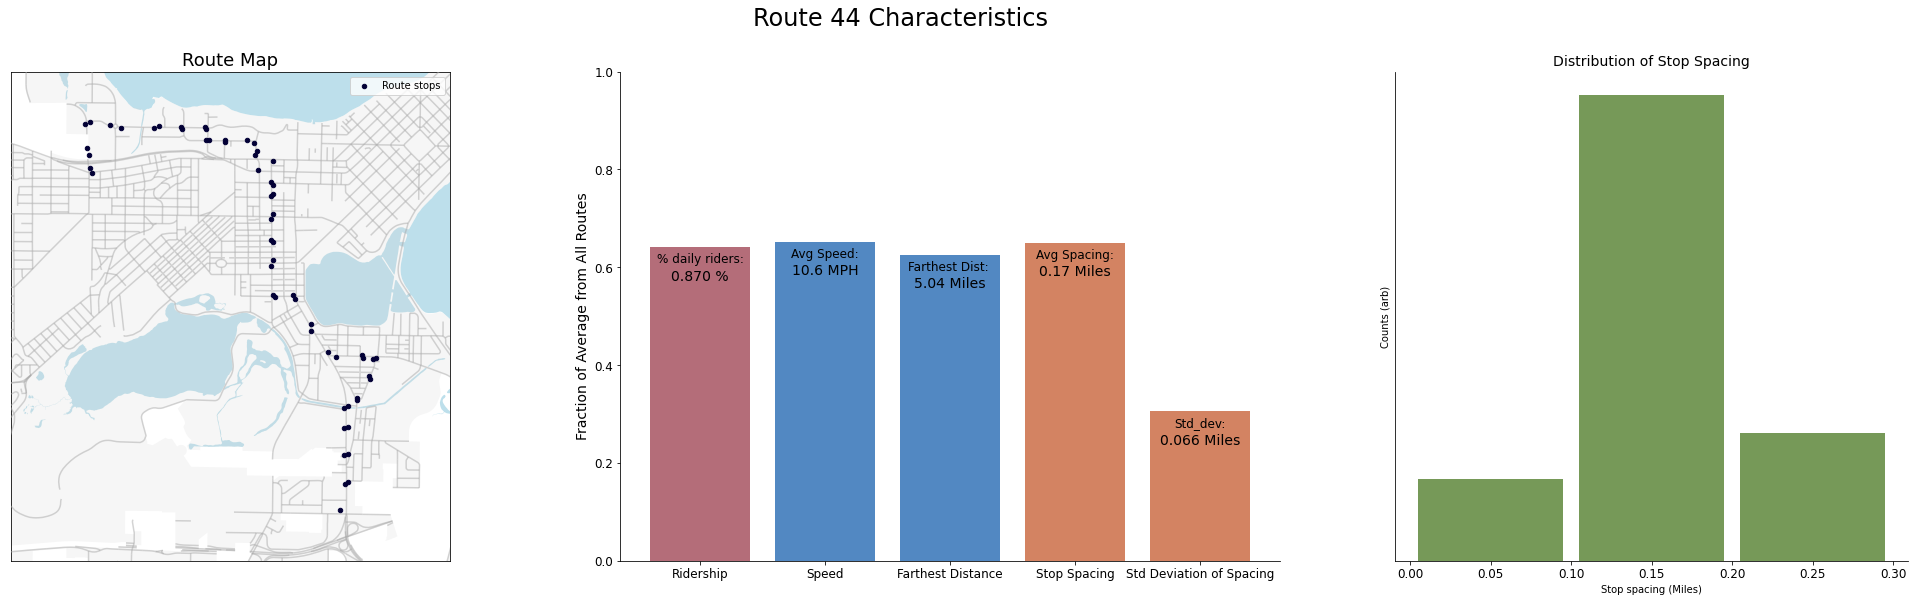

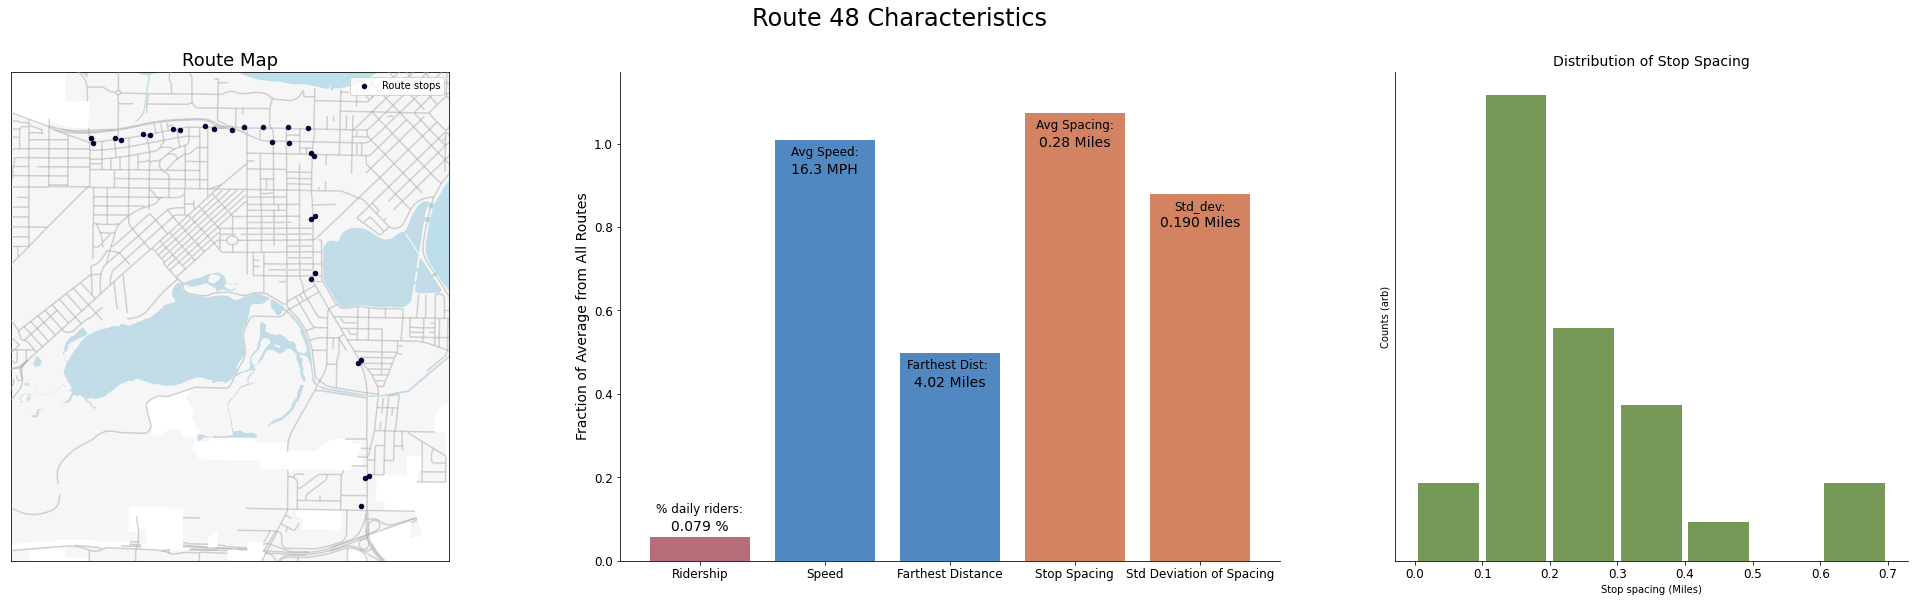

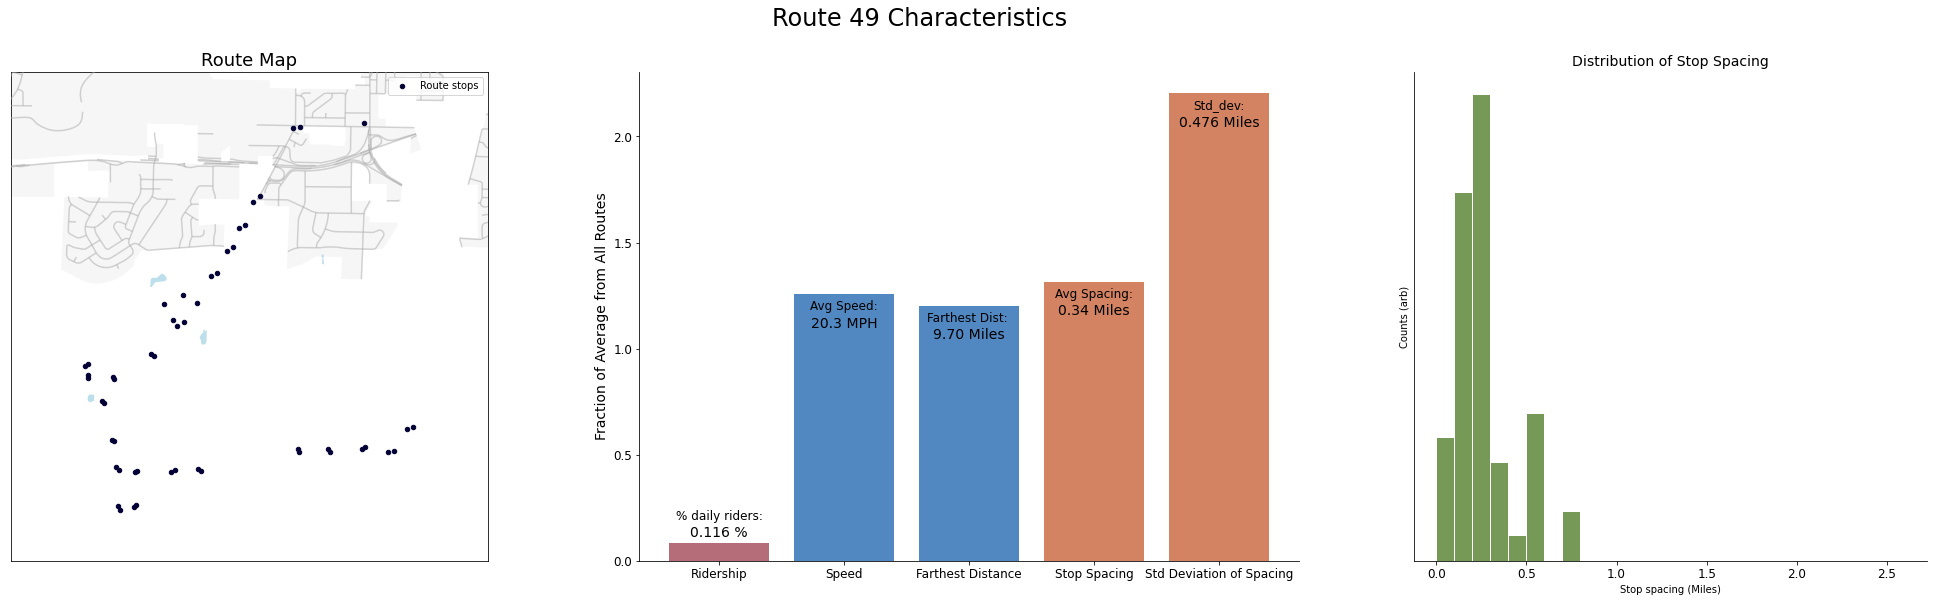

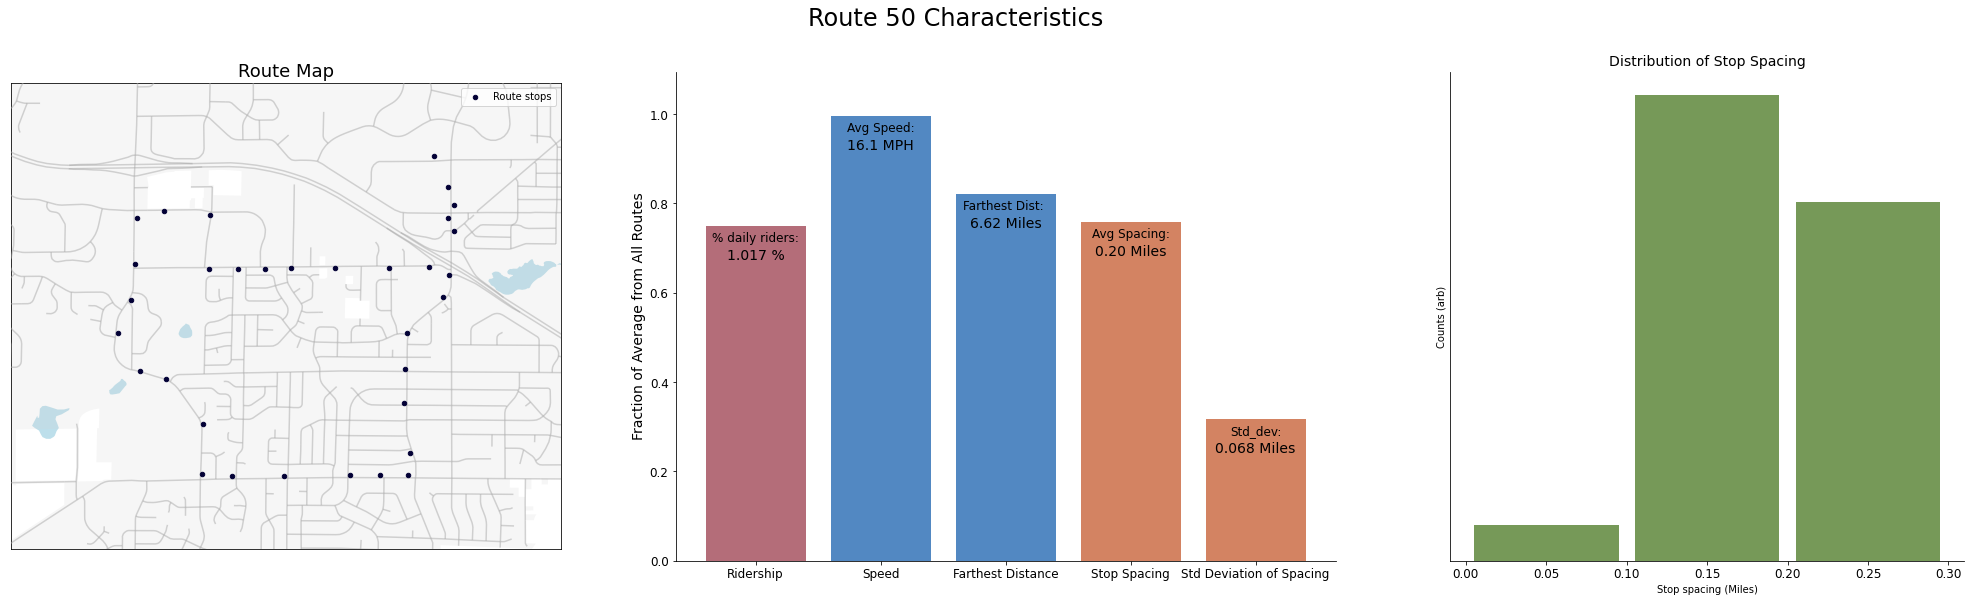

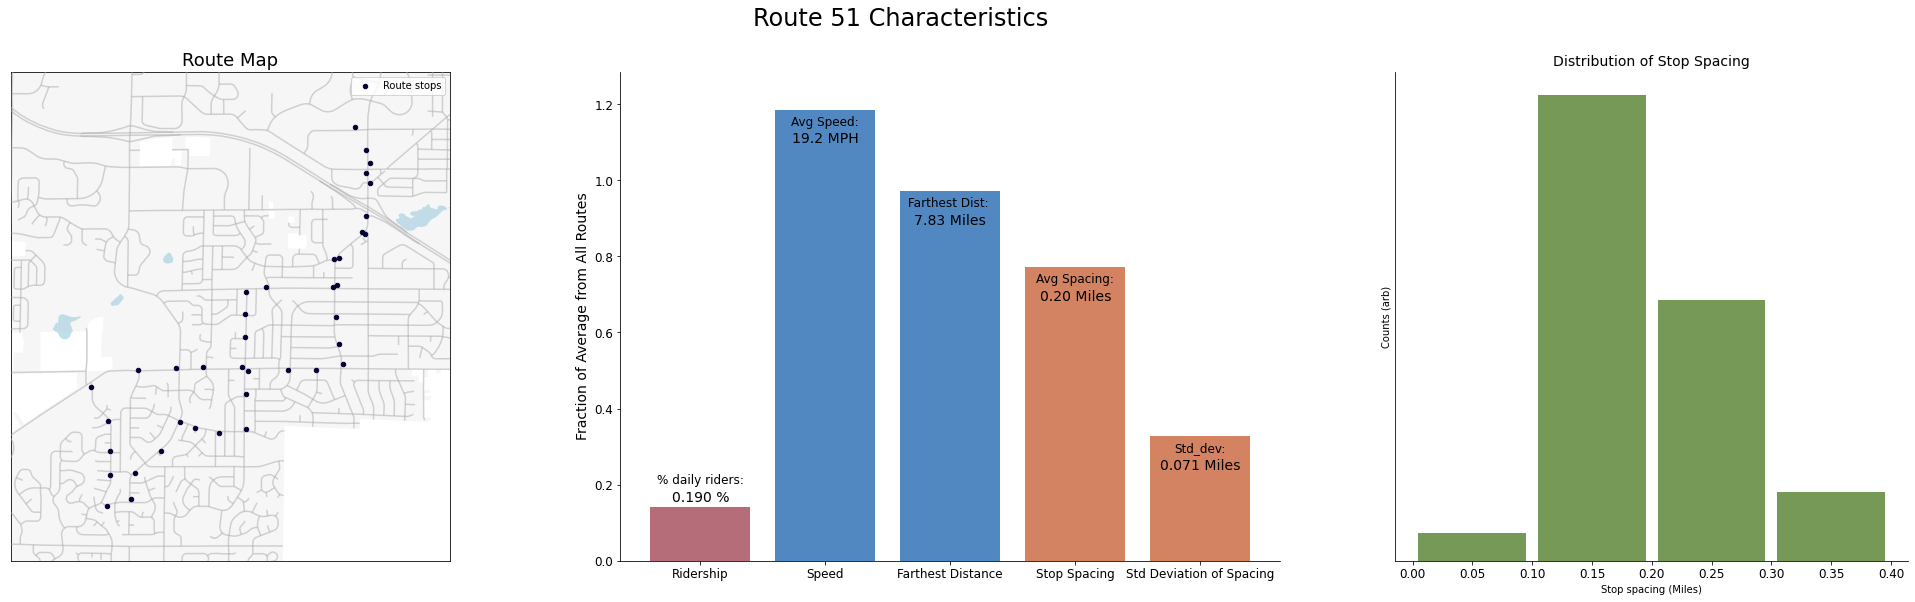

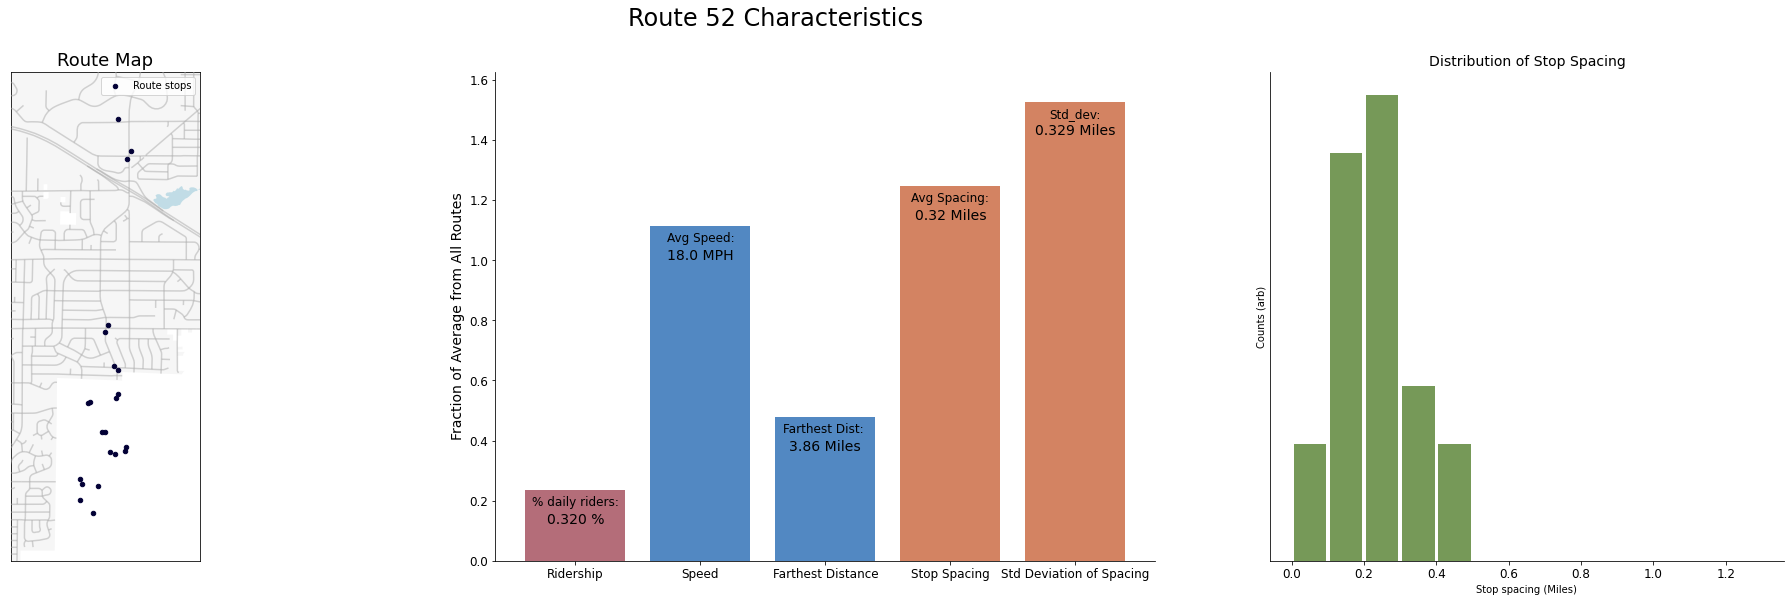

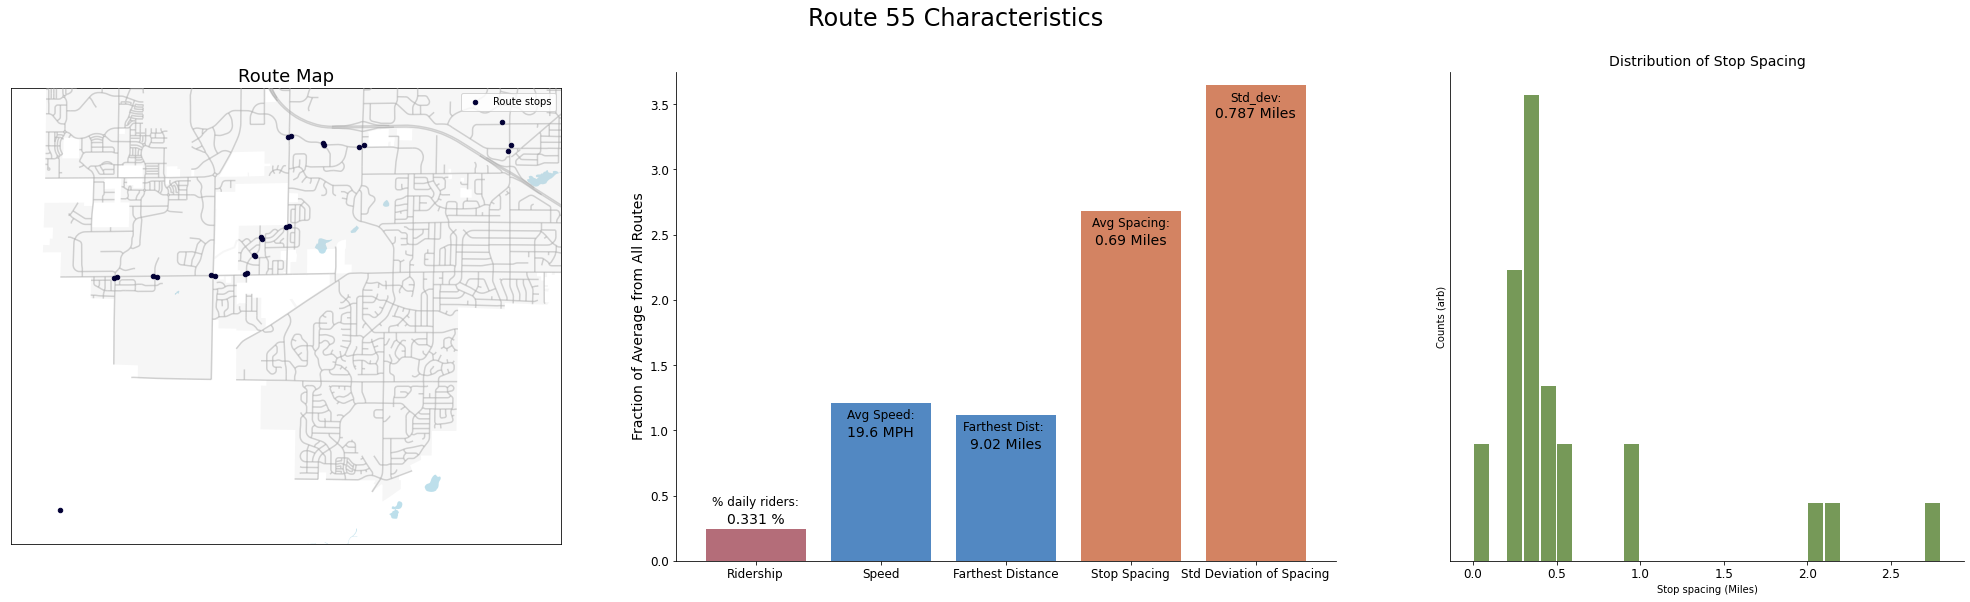

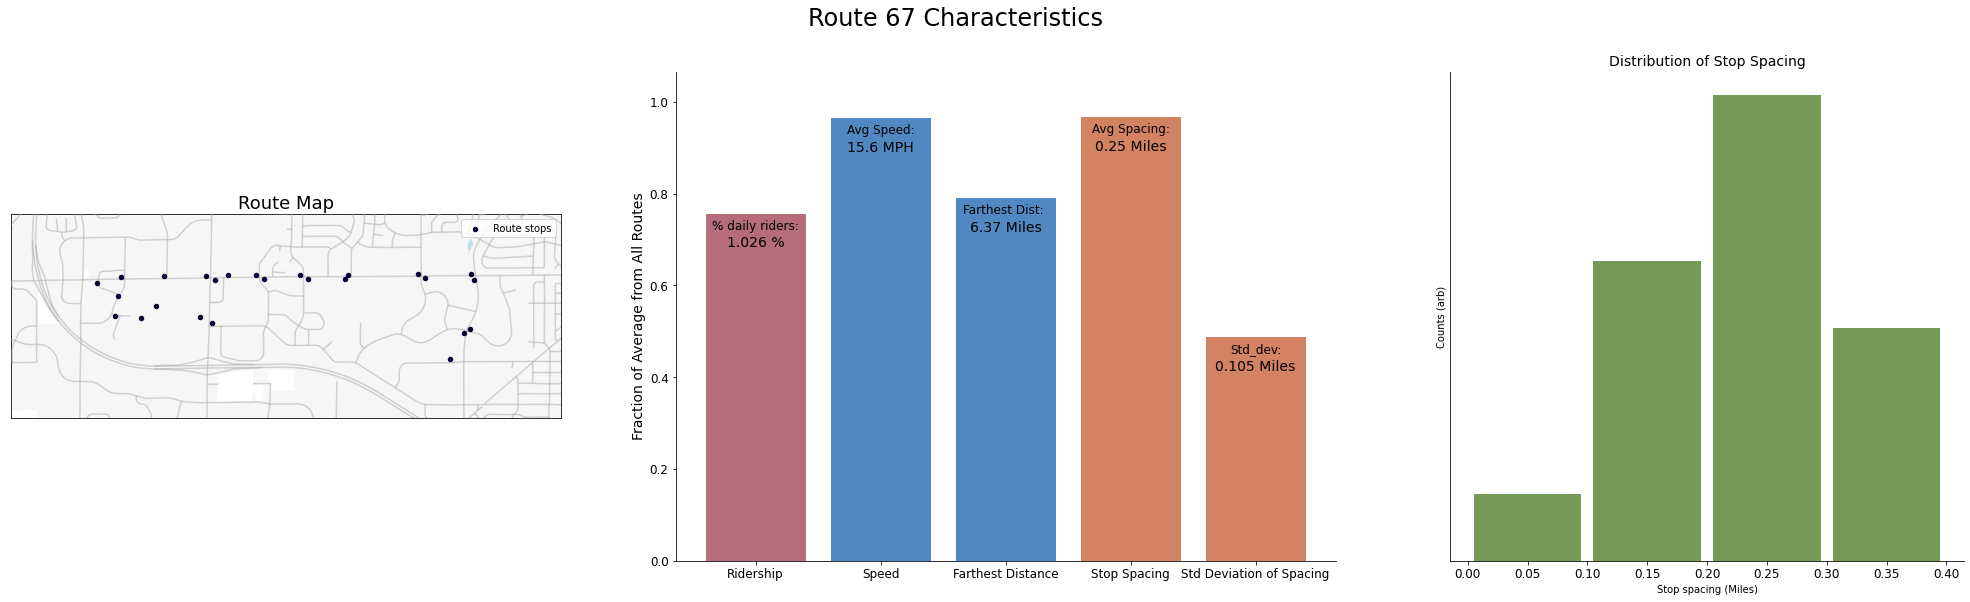

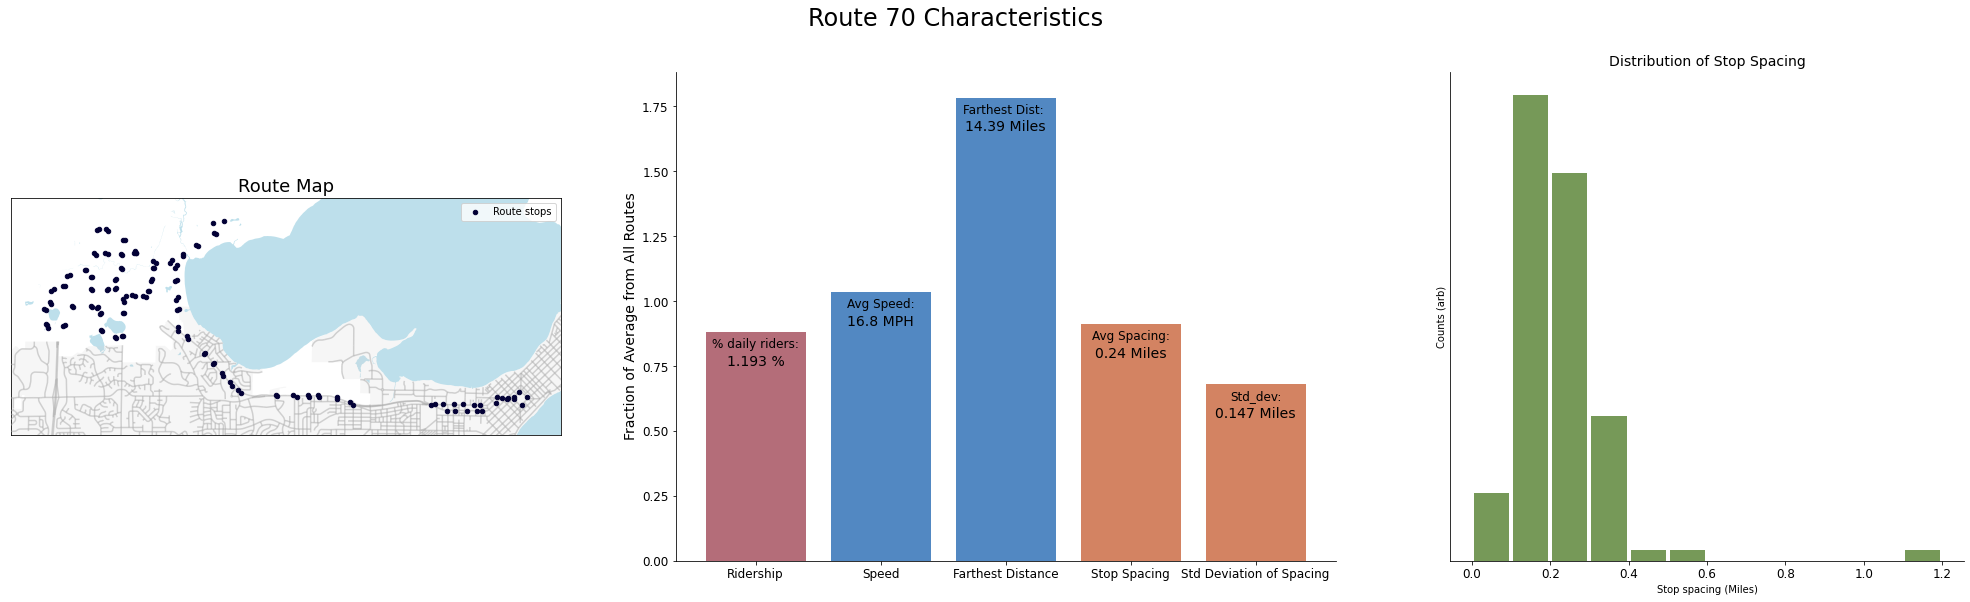

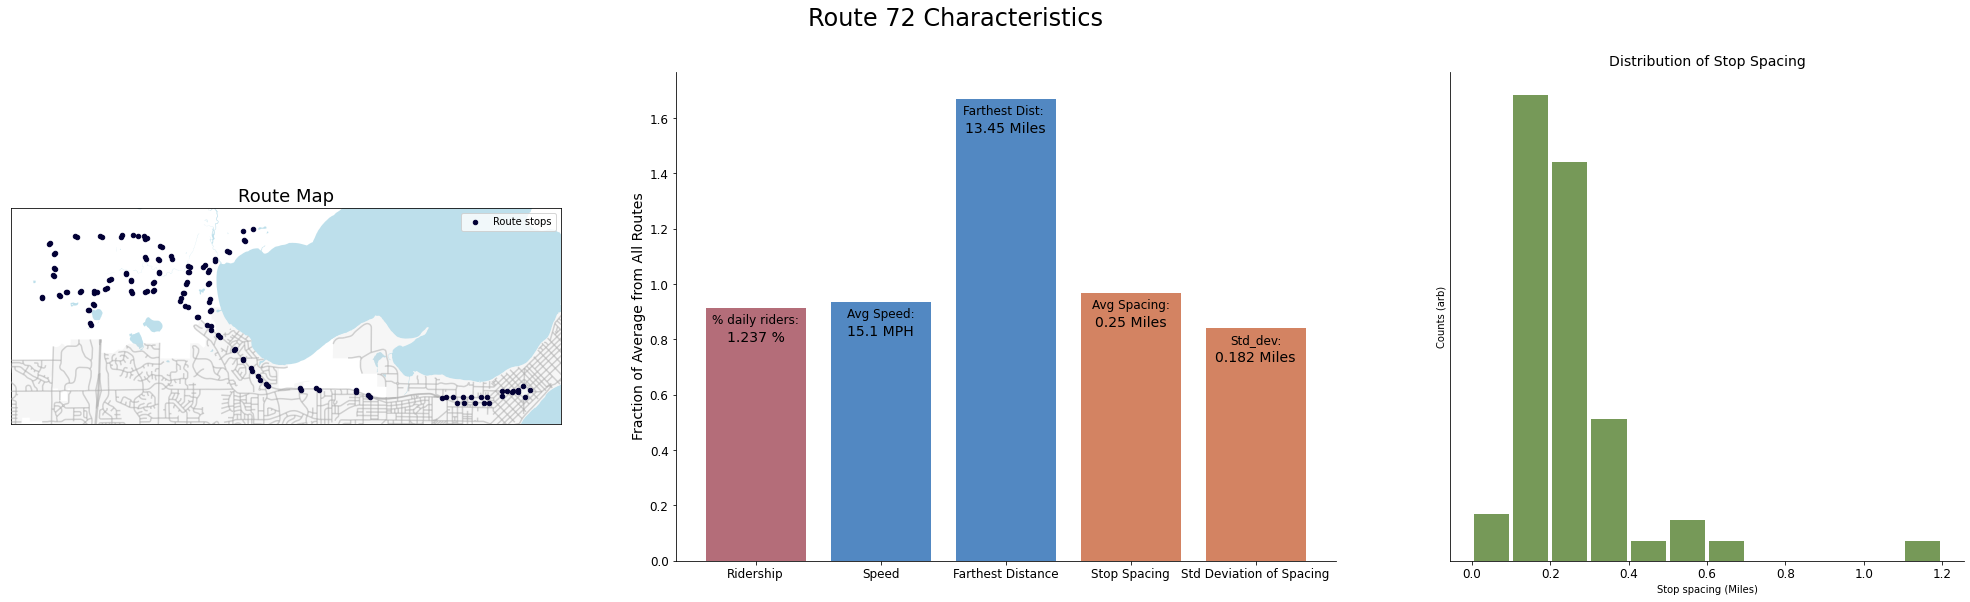

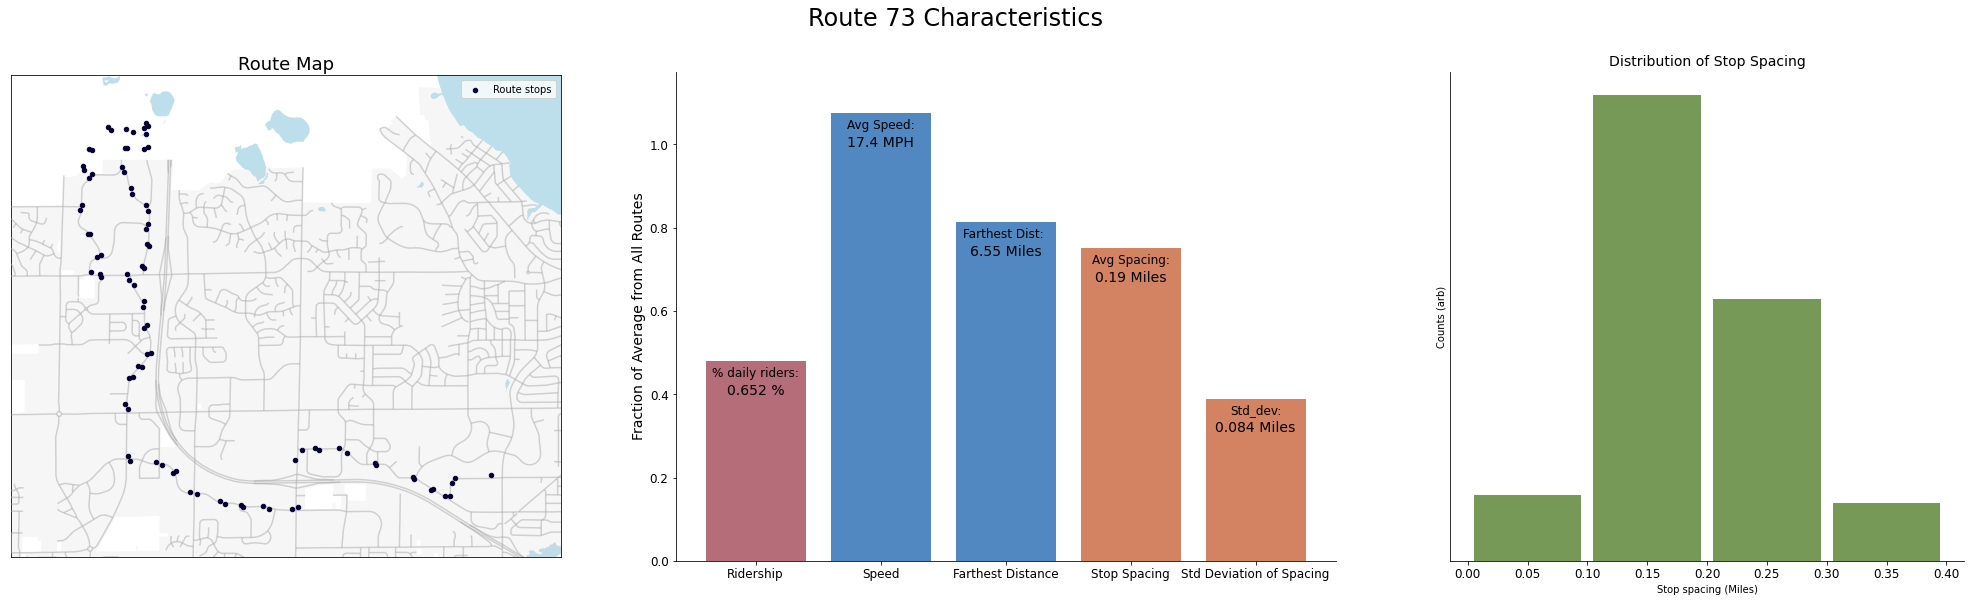

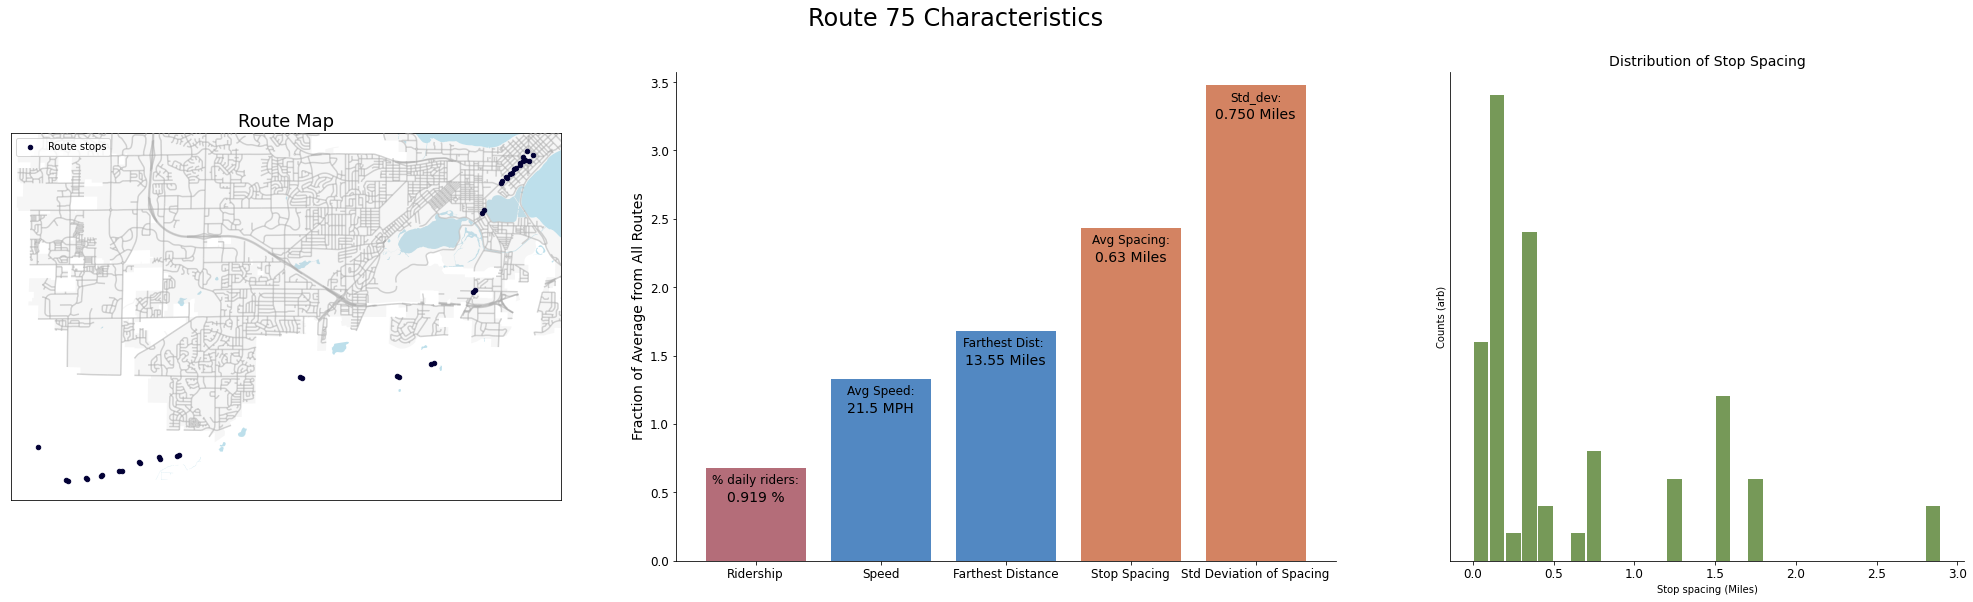

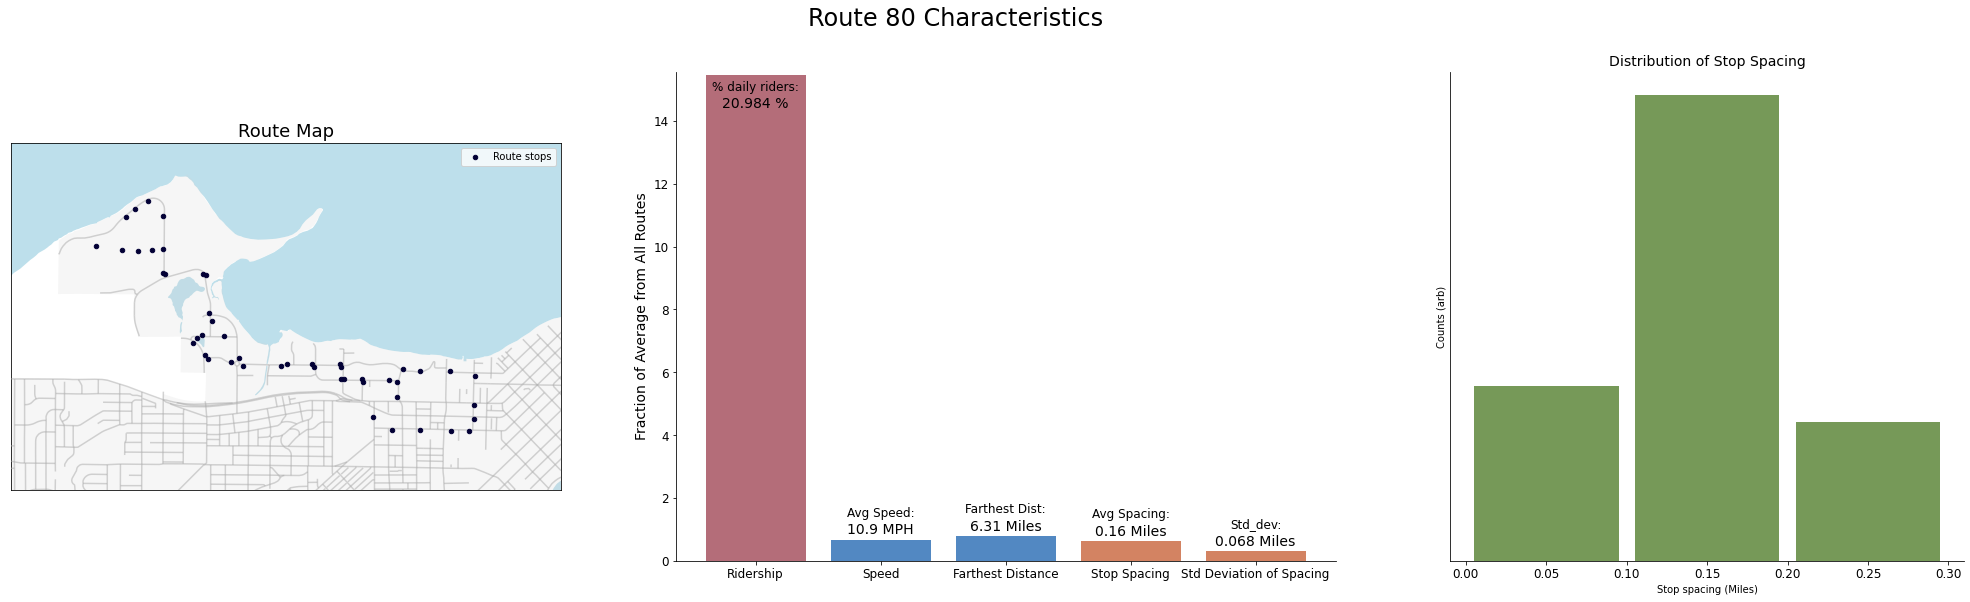

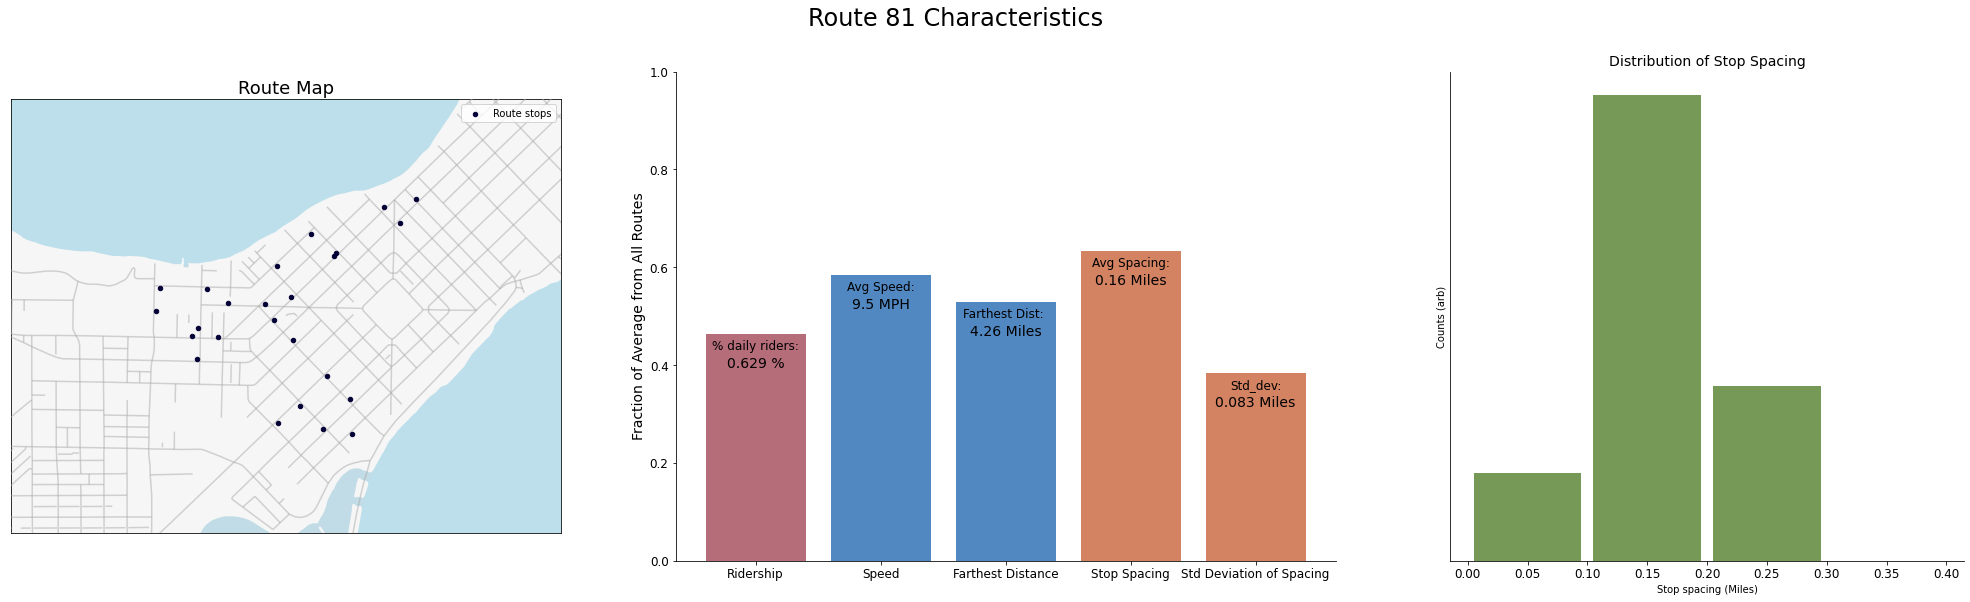

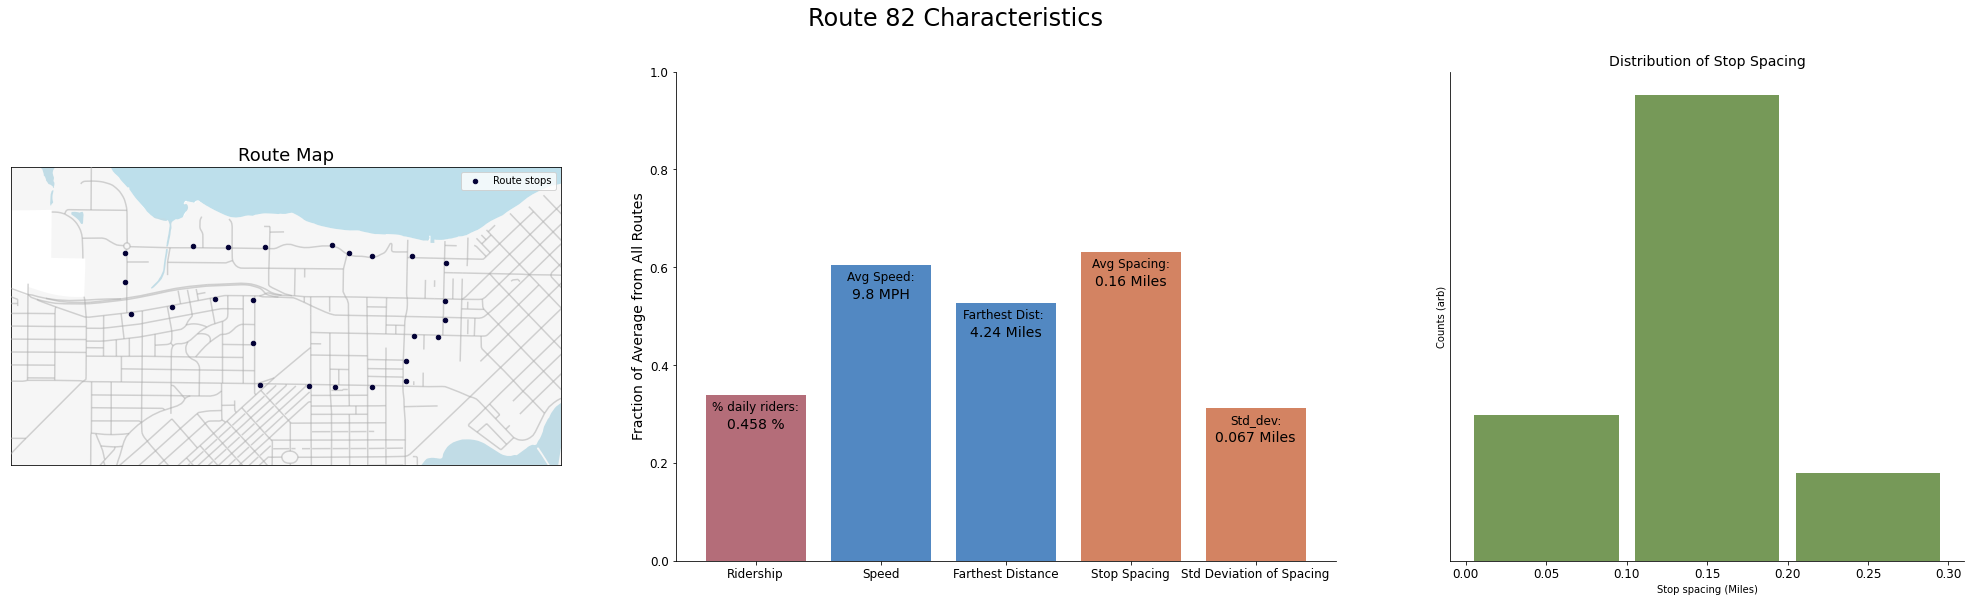

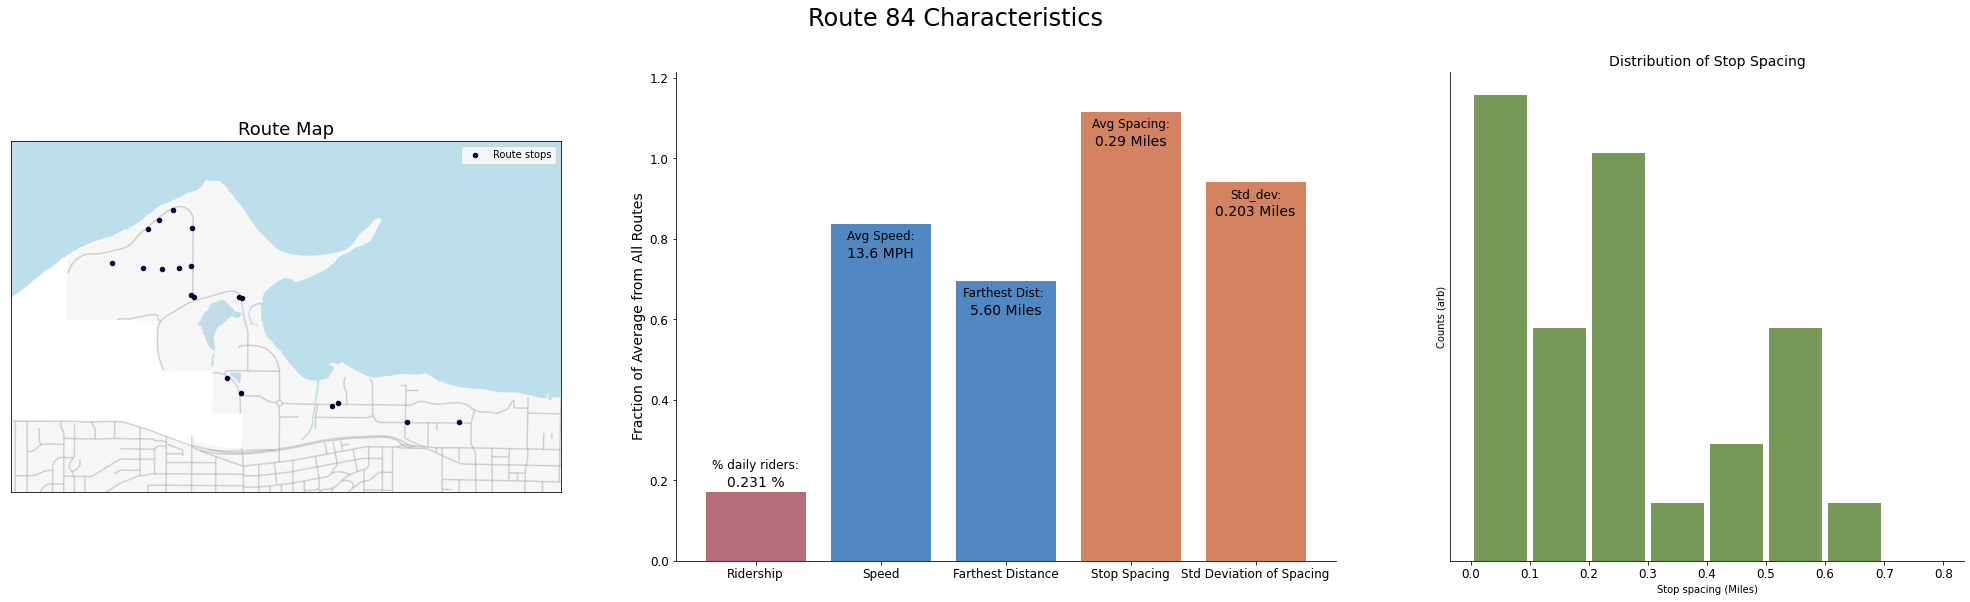

In [45]:
for route in routes_wk_list:
    plotRouteCharacteristics_colors(route)

## Investigate lowest stop spacing and lowest ridership -- seems like the best for rebalancing

* Exclude UW routes: 80, 81, 82 - different purpose

focus on: 

- 36
- 32
- 44
- 27
- 51

In [30]:
"""print(routes_wk_list)"""

'print(routes_wk_list)'

In [31]:
"""subRoutes = (27, 32, 44, 51)

Routes_latLon = dict()

for route in routes_wk_list:
    lat = []
    lon = []
    stops = route_stops[route]
    for stop in stops:
        stops_local = stops_df[stops_df['stop_id'] == stop]
        lat.append(float(stops_local['stop_lat']))
        lon.append(float(stops_local['stop_lon']))
    Routes_latLon[route] = [lat, lon]
    
#subRoutes_latLon[27][0][:2]"""

"subRoutes = (27, 32, 44, 51)\n\nRoutes_latLon = dict()\n\nfor route in routes_wk_list:\n    lat = []\n    lon = []\n    stops = route_stops[route]\n    for stop in stops:\n        stops_local = stops_df[stops_df['stop_id'] == stop]\n        lat.append(float(stops_local['stop_lat']))\n        lon.append(float(stops_local['stop_lon']))\n    Routes_latLon[route] = [lat, lon]\n    \n#subRoutes_latLon[27][0][:2]"

In [32]:
"""riderships = []
for route in route_characteristics:
    if route == 80: 
        continue
    riderships.append(route_characteristics[route][2])

ridership_avg_no_80 = np.average(riderships)
ridership_avg_no_80"""

'riderships = []\nfor route in route_characteristics:\n    if route == 80: \n        continue\n    riderships.append(route_characteristics[route][2])\n\nridership_avg_no_80 = np.average(riderships)\nridership_avg_no_80'

In [33]:
"""Speeds = []
for route in route_characteristics:
    if route == 80: 
        continue
    Speeds.append(route_characteristics[route][0])

Speeds_avg_no_80 = np.average(Speeds)
Speeds_avg_no_80"""

'Speeds = []\nfor route in route_characteristics:\n    if route == 80: \n        continue\n    Speeds.append(route_characteristics[route][0])\n\nSpeeds_avg_no_80 = np.average(Speeds)\nSpeeds_avg_no_80'

In [34]:
"""spacing = []
for route in route_characteristics:
    if route == 80: 
        continue
    spacing.append(route_characteristics[route][1])

Spacing_avg_no_80 = np.average(spacing)
Spacing_avg_no_80"""

'spacing = []\nfor route in route_characteristics:\n    if route == 80: \n        continue\n    spacing.append(route_characteristics[route][1])\n\nSpacing_avg_no_80 = np.average(spacing)\nSpacing_avg_no_80'

In [35]:
"""def plotRouteCharacteristics(route, save=True):
    ax = plt.subplots(1, 2, figsize=(20, 11), frameon=False)[1]

    ### Plot 1: Add the geopandas backgroud:
    city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)
    lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)
    Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)

    ### Plot 2: Add the routes on top:
    x = Routes_latLon[route][1]
    y = Routes_latLon[route][0]
    
    # Look for specific colors or default to green
    try:
        ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors[route][0], zorder=4)
    except:
        ax[0].scatter(x, y, label="Route "+str(route)+" stops", color="#2b5d34", zorder=4)
        
    ax[0].set_xlim(min(Routes_latLon[route][1])-.01, max(Routes_latLon[route][1])+.01)
    ax[0].set_ylim(min(Routes_latLon[route][0])-.005, max(Routes_latLon[route][0])+.005)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].legend()
    ax[0].set_title("Route Stops for Weekday Trips:", fontsize=16)

    ### Plot 3: Bar plot to the right summarizing stats
    ridership_perc_avg = route_characteristics[route][2]/ridership_avg_no_80
    speed_perc_avg = route_characteristics[route][0]/Speeds_avg_no_80
    spacing_perc_avg = route_characteristics[route][1]/Spacing_avg_no_80

    x_labels = ["Ridership", "Speed", "Stop Spacing"]
    hist_x = (1, 2, 3)
    width = .8
    hist_heights = (ridership_perc_avg, speed_perc_avg, spacing_perc_avg)
    
    # Look for specific colors or default to green
    try:
        ax[1].bar(x=hist_x, height=hist_heights, color=colors[route][1], tick_label=x_labels, width = width, alpha=.8)
    except:
        ax[1].bar(x=hist_x, height=hist_heights, color="#74a662", tick_label=x_labels, width = width, alpha=.8)

    # Place text above bars that too small:
    ylim = max(1, speed_perc_avg+.1, ridership_perc_avg+.1, spacing_perc_avg+.1) 
    if ridership_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)  
    else:
        ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)

    if speed_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)
    else:
        ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)

    if spacing_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)
    else:
        ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)

    ax[1].tick_params(labelsize=12)
    ax[1].set_ylabel("Fraction of Average from All Routes", fontsize=14)
    ax[1].set_ylim(0, ylim)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)

    if save == True:
        plt.savefig("Route_characterstics_" + str(route))
    #plt.show()
    
    return ax"""

'def plotRouteCharacteristics(route, save=True):\n    ax = plt.subplots(1, 2, figsize=(20, 11), frameon=False)[1]\n\n    ### Plot 1: Add the geopandas backgroud:\n    city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)\n    lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)\n    Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)\n\n    ### Plot 2: Add the routes on top:\n    x = Routes_latLon[route][1]\n    y = Routes_latLon[route][0]\n    \n    # Look for specific colors or default to green\n    try:\n        ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors[route][0], zorder=4)\n    except:\n        ax[0].scatter(x, y, label="Route "+str(route)+" stops", color="#2b5d34", zorder=4)\n        \n    ax[0].set_xlim(min(Routes_latLon[route][1])-.01, max(Routes_latLon[route][1])+.01)\n    ax[0].set_ylim(min(Routes_latLon[route][0])-.005, max(Routes_latLon[route][0])+.005)\n    ax[0].set_xticks([])\n    ax[0].set_yticks([])\n    ax[0].legend()\n 

In [36]:
colors = {27: ["#2b5d34", "#74a662"], 32:["#5f1b6b", "#895b7b"], 44:["#475f94", "#77a1b5"], 51:["#730039", "#b9484e"]}

In [37]:
"""plotRouteCharacteristics(27)"""

'plotRouteCharacteristics(27)'

In [38]:
"""plotRouteCharacteristics(32)"""

'plotRouteCharacteristics(32)'

In [39]:
"""plotRouteCharacteristics(44)"""

'plotRouteCharacteristics(44)'

In [40]:
"""plotRouteCharacteristics(51)"""

'plotRouteCharacteristics(51)'

In [41]:
"""plotRouteCharacteristics(2, save=False)"""

'plotRouteCharacteristics(2, save=False)'

In [42]:
"""colors_5 = {1: ["#2b5d34", "#74a662"], 2:["#5f1b6b", "#895b7b"], 3:["#475f94", "#77a1b5"], 4:["#730039", "#b9484e"], 5:["#c9643b", "#ff9408"]}"""

'colors_5 = {1: ["#2b5d34", "#74a662"], 2:["#5f1b6b", "#895b7b"], 3:["#475f94", "#77a1b5"], 4:["#730039", "#b9484e"], 5:["#c9643b", "#ff9408"]}'

In [43]:
"""def plotRouteCharacteristics_colors(route, count):
    ax = plt.subplots(1, 2, figsize=(20, 11), frameon=False)[1]

    ### Plot 1: Add the geopandas backgroud:
    city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)
    lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)
    Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)

    ### Plot 2: Add the routes on top:
    x = Routes_latLon[route][1]
    y = Routes_latLon[route][0]
    
    # Look for specific colors or default to green
    ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors_5[count][0], zorder=4)
        
    ax[0].set_xlim(min(Routes_latLon[route][1])-.01, max(Routes_latLon[route][1])+.01)
    ax[0].set_ylim(min(Routes_latLon[route][0])-.005, max(Routes_latLon[route][0])+.005)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].legend()
    ax[0].set_title("Route Stops for Weekday Trips:", fontsize=16)

    ### Plot 3: Bar plot to the right summarizing stats
    ridership_perc_avg = route_characteristics[route][2]/ridership_avg_no_80
    speed_perc_avg = route_characteristics[route][0]/Speeds_avg_no_80
    spacing_perc_avg = route_characteristics[route][1]/Spacing_avg_no_80

    x_labels = ["Ridership", "Speed", "Stop Spacing"]
    hist_x = (1, 2, 3)
    width = .8
    hist_heights = (ridership_perc_avg, speed_perc_avg, spacing_perc_avg)
    
    # Look for specific colors or default to green
    ax[1].bar(x=hist_x, height=hist_heights, color=colors_5[count][1], tick_label=x_labels, width = width, alpha=.8)

    # Place text above bars that too small:
    ylim = max(1, speed_perc_avg+.1, ridership_perc_avg+.1, spacing_perc_avg+.1) 
    if ridership_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)  
    else:
        ax[1].annotate("% of daily riders: \n", xy=(1, ridership_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.3f} %'.format(route_characteristics[route][2]*100), xy=(1, ridership_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)

    if speed_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)
    else:
        ax[1].annotate("Average Speed: \n", xy=(2, speed_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.1f} MPH'.format(route_characteristics[route][0]), xy=(2, speed_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)

    if spacing_perc_avg-.04*ylim < .1*ylim:
        ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg+.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg+.02*ylim), ha='center', va='center', fontsize=14)
    else:
        ax[1].annotate("Average Spacing: \n", xy=(3, spacing_perc_avg-.04*ylim), ha='center', va='center', fontsize=12)
        ax[1].annotate('{0:^.2f} Miles'.format(route_characteristics[route][1]), xy=(3, spacing_perc_avg-.06*ylim), ha='center', va='center', fontsize=14)

    ax[1].tick_params(labelsize=12)
    ax[1].set_ylabel("Fraction of Average from All Routes", fontsize=14)
    ax[1].set_ylim(0, ylim)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)


    plt.savefig("Route_" + str(route), bbox_inches='tight')
    plt.show()"""

'def plotRouteCharacteristics_colors(route, count):\n    ax = plt.subplots(1, 2, figsize=(20, 11), frameon=False)[1]\n\n    ### Plot 1: Add the geopandas backgroud:\n    city.plot(color="lightgray", alpha=.2, ax=ax[0], zorder=2)\n    lakes.plot(color="lightblue", ax=ax[0], zorder=1, alpha=.8)\n    Street.plot(color="darkgray", alpha = .5, ax=ax[0], zorder=3)\n\n    ### Plot 2: Add the routes on top:\n    x = Routes_latLon[route][1]\n    y = Routes_latLon[route][0]\n    \n    # Look for specific colors or default to green\n    ax[0].scatter(x, y, label="Route "+str(route)+" stops", color=colors_5[count][0], zorder=4)\n        \n    ax[0].set_xlim(min(Routes_latLon[route][1])-.01, max(Routes_latLon[route][1])+.01)\n    ax[0].set_ylim(min(Routes_latLon[route][0])-.005, max(Routes_latLon[route][0])+.005)\n    ax[0].set_xticks([])\n    ax[0].set_yticks([])\n    ax[0].legend()\n    ax[0].set_title("Route Stops for Weekday Trips:", fontsize=16)\n\n    ### Plot 3: Bar plot to the right summari

In [44]:
"""for i, route in enumerate(routes_wk_list):
    countNew = random.randint(1, 5)
    if i == 0:
        countOld = 0
    while(countNew == countOld):
        countNew = random.randint(1, 5)

    plotRouteCharacteristics_colors(route, countNew)
    
    countOld = countNew"""

'for i, route in enumerate(routes_wk_list):\n    countNew = random.randint(1, 5)\n    if i == 0:\n        countOld = 0\n    while(countNew == countOld):\n        countNew = random.randint(1, 5)\n\n    plotRouteCharacteristics_colors(route, countNew)\n    \n    countOld = countNew'